In [1]:
#Import tensorflow

import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#Test if GPU is found

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


In [3]:
#Autosaving every 10s

%autosave 10

Autosaving every 10 seconds


In [4]:
#Training & Testing files

train_file = "train17.csv"
val_file = "val17.csv"
matlab_file = '1_50_17.mat'
rul_file = "rul_50_17.csv"
fleet_Rul_File = "rul17.csv"
test_file = "test17.csv"

In [5]:
import pandas as pd
import numpy as np
import scipy.io
import tensorflow_probability as tfp
import matplotlib as plt
import matplotlib.pyplot as plt
import pickle
import scipy.io as spio
import pickle
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential, model_from_json, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Masking
tfd = tfp.distributions

In [6]:
#fix random seed for reproducibility

np.random.seed(0)

In [7]:
#load Training & Testing files into Pandas Dataframes

train = pd.read_csv(train_file, index_col=False)
val = pd.read_csv(val_file, index_col=False)
mat = spio.loadmat(matlab_file, squeeze_me=True)

C:\Users\Asus\anaconda3\lib\site-packages\scipy\io\matlab\mio.py:218: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [8]:
#Load Hyperparameters Obtained by BayesOpt

lr = mat['lr']
ep = mat['ep']
batch = mat['batch']
pad = mat['Pad']
L2 = mat['L2'] 
unit1 = mat['unit'] 
size1 = mat['size']
drop1 = mat['drop']

lr,ep,batch,pad,L2,unit1,size1,drop1

(0.0005025687893372792, 1e-08, 88, 303, 0.0001, 64, 364, 0.35644088162095944)

In [9]:
#Xtrain to Numpy multidimensional array

xtrain_cut = train.drop(['Fleet','Cycle','RUL'], axis=1)
xtrain = np.zeros((train['Fleet'].max(),pad,xtrain_cut.shape[1]))
for i in range(train['Fleet'].max()):
    df_xtrain = train.loc[train['Fleet']==i+1]
    df_xtrain = df_xtrain.drop(['Fleet','Cycle','RUL'], axis=1)
    np_xtrain = df_xtrain.values
    result = np.zeros((pad,df_xtrain.shape[1]))
    result[:np_xtrain.shape[0],:np_xtrain.shape[1]] = np_xtrain
    xtrain[i] = result
xtrain.shape

(100, 303, 17)

In [10]:
#Ytrain to Numpy multidimensional array

ytrain_cut = train[['RUL']]
ytrain = np.zeros((train['Fleet'].max(),pad,1))
for i in range(train['Fleet'].max()):
    df_ytrain = train.loc[train['Fleet']==i+1]
    df_ytrain = df_ytrain[['RUL']]
    np_ytrain = df_ytrain.values
    result = np.zeros((pad,df_ytrain.shape[1]))
    result[:np_ytrain.shape[0],:np_ytrain.shape[1]] = np_ytrain
    ytrain[i] = result
ytrain.shape

(100, 303, 1)

In [11]:
#Ytrain2 to Numpy multidimensional array - for SHAP

ytrain2 = np.zeros(train['Fleet'].max())
for i in range(train['Fleet'].max()):
    df_ytrain2 = train.loc[train['Fleet']==i+1]
    df_ytrain2 = df_ytrain2[['RUL']].values
    ytrain2[i] = df_ytrain2[0]
ytrain2.shape

(100,)

In [12]:
#Xval to Numpy multidimensional array

xval_cut = val.drop(['RUL','Fleet','Cycle'], axis=1)
xval = np.zeros((val['Fleet'].max(),pad,xval_cut.shape[1]))
for i in range(val['Fleet'].max()):
    df_xval = val.loc[val['Fleet']==i+1]
    df_xval = df_xval.drop(['Fleet','Cycle','RUL'], axis=1)
    np_xval = df_xval.values
    result = np.zeros((pad,df_xval.shape[1]))
    result[:np_xval.shape[0],:np_xval.shape[1]] = np_xval
    xval[i] = result
xval.shape

(100, 303, 17)

In [13]:
#Yval to Numpy multidimensional array - for sequential prediction 

yval_cut = val[['RUL']]
yval = np.zeros((val['Fleet'].max(),pad,1))
for i in range(val['Fleet'].max()):
    df_yval = val.loc[val['Fleet']==i+1]
    df_yval = df_yval[['RUL']]
    np_yval = df_yval.values
    result = np.zeros((pad,df_yval.shape[1]))
    result[:np_yval.shape[0],:np_yval.shape[1]] = np_yval
    yval[i] = result
yval.shape

(100, 303, 1)

In [14]:
#Yval2 to Numpy multidimensional array - for SHAP 

yval2 = np.zeros(train['Fleet'].max())
for i in range(train['Fleet'].max()):
    df_yval2 = train.loc[train['Fleet']==i+1]
    df_yval2 = df_yval2[['RUL']].values
    yval2[i] = df_yval2[0]
yval2.shape

(100,)

In [15]:
#xtest to Numpy multidimensional array 

test = pd.read_csv(test_file, index_col=False)
xtest_cut = test.drop(['Fleet','Cycle'], axis=1)
xtest = np.zeros((test['Fleet'].max(),pad,xtest_cut.shape[1]))
for i in range(test['Fleet'].max()):
    df_xtest = test.loc[test['Fleet']==i+1]
    df_xtest = df_xtest.drop(['Fleet','Cycle'], axis=1)
    np_xtest = df_xtest.values
    result = np.zeros((pad,df_xtest.shape[1]))
    result[:np_xtest.shape[0],:np_xtest.shape[1]] = np_xtest
    xtest[i] = result

In [16]:
#Verify shapes of array

xtrain.shape,ytrain.shape, ytrain2.shape,xval.shape,yval.shape,yval2.shape,xtest.shape

((100, 303, 17),
 (100, 303, 1),
 (100,),
 (100, 303, 17),
 (100, 303, 1),
 (100,),
 (100, 303, 17))

In [17]:
xtrain = xtrain.astype(np.float32)
ytrain = ytrain.astype(np.float32)
ytrain2 = ytrain2.astype(np.float32)
xval = xval.astype(np.float32)
yval = yval.astype(np.float32)
yval2 = yval2.astype(np.float32)
xtest = xtest.astype(np.float32)

In [18]:
#Set ytrain,yval for 3 outputs

x_train = xtrain
y_train = [ytrain,ytrain,ytrain2]
x_val = xval
y_val = [yval,yval,yval2]
x_test = xtest

In [19]:
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback,ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Reshape
import warnings
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.models import Model
from IPython.display import display

In [20]:
# Define trainable prior

def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

#Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [21]:
#Define probabilistic LSTM

#LSTM layers

inputs = tf.keras.Input(shape=(303,17),dtype='float32')
layer1 = LSTM(unit1,return_sequences = True)(inputs)
layer2 = Dense(size1)(layer1)

#Output 1 = Aleatoric output layer

layer3 = Dense(1+1)(layer2)
layer4 = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1],scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:])),name='out1')(layer3) #aleatoric

#Output 2 = Epistemic output layer

layer5 = tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable)(layer2)
layer6 = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1),name = 'out2')(layer5)

#Output 3 = Slicer output layer

layer7 = Dense(1)(layer2)
layer8 = Lambda(lambda t: t[:,-1],name='out3')(layer7)

model = tf.keras.Model(inputs=inputs, outputs=[layer4,layer6,layer8])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 303, 17)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 303, 64)      20992       input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 303, 364)     23660       lstm[0][0]                       
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 303, 2)       730         dense[0][0]                      
_______________________________________________________________________________________

In [22]:
#Define directory for best weights checkpoint

import os
checkpoint_path = "C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/Gas Turbine & Turbofan AD & PROGNOS/Turbofan/Turbofan-1 LSTM 17/model checkpoint/1_50_17_ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

#Callback for best weights checkpoint

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose = 1)

In [23]:
#Compile model

optimizers.Adam(learning_rate=lr, beta_1 = 0.9,beta_2 = 0.999, epsilon = ep, amsgrad = False, name = "Adam")
negloglik = lambda y, rv_y: -rv_y.log_prob(y)
model.compile(loss = {'out1': negloglik,'out2': negloglik,'out3':'mean_squared_error'},loss_weights=[0.5,0.5,0],optimizer= 'Adam')

In [24]:
#Set Tensorboard  

%load_ext tensorboard
import tensorboard
tensorboard.__version__
from datetime import datetime
from tensorflow import keras
#Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [27]:
#Run training

history = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 10000, batch_size  = batch, verbose = 0, callbacks=[model_checkpoint_callback,tensorboard_callback])

Instructions for updating:
use `tf.profiler.experimental.stop` instead.

Epoch 00001: val_loss improved from inf to 211.71805, saving model to C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/New folder/P2/model checkpoint\1_50_clean_ckpt

Epoch 00002: val_loss did not improve from 211.71805

Epoch 00003: val_loss did not improve from 211.71805

Epoch 00004: val_loss improved from 211.71805 to 207.94345, saving model to C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/New folder/P2/model checkpoint\1_50_clean_ckpt

Epoch 00005: val_loss improved from 207.94345 to 197.77115, saving model to C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/New folder/P2/model checkpoint\1_50_clean_ckpt

Epoch 00006: val_loss improved from 197.77115 to 195.79681, saving model to C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/New folder/P2/model checkpoint\1_50_clean_ckpt

Epoch 00007: val_loss improved from 195.79681 to 194.41475, saving model to C:/Users/Asus/OneDrive - Universi


Epoch 00097: val_loss did not improve from 21.39958

Epoch 00098: val_loss did not improve from 21.39958

Epoch 00099: val_loss did not improve from 21.39958

Epoch 00100: val_loss did not improve from 21.39958

Epoch 00101: val_loss did not improve from 21.39958

Epoch 00102: val_loss did not improve from 21.39958

Epoch 00103: val_loss improved from 21.39958 to 20.95087, saving model to C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/New folder/P2/model checkpoint\1_50_clean_ckpt

Epoch 00104: val_loss improved from 20.95087 to 20.84045, saving model to C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/New folder/P2/model checkpoint\1_50_clean_ckpt

Epoch 00105: val_loss did not improve from 20.84045

Epoch 00106: val_loss did not improve from 20.84045

Epoch 00107: val_loss did not improve from 20.84045

Epoch 00108: val_loss did not improve from 20.84045

Epoch 00109: val_loss improved from 20.84045 to 19.81343, saving model to C:/Users/Asus/OneDrive - Universiti Tekno

Epoch 00224: val_loss did not improve from 10.68595

Epoch 00225: val_loss did not improve from 10.68595

Epoch 00226: val_loss did not improve from 10.68595

Epoch 00227: val_loss did not improve from 10.68595

Epoch 00228: val_loss did not improve from 10.68595

Epoch 00229: val_loss did not improve from 10.68595

Epoch 00230: val_loss did not improve from 10.68595

Epoch 00231: val_loss did not improve from 10.68595

Epoch 00232: val_loss did not improve from 10.68595

Epoch 00233: val_loss did not improve from 10.68595

Epoch 00234: val_loss did not improve from 10.68595

Epoch 00235: val_loss did not improve from 10.68595

Epoch 00236: val_loss did not improve from 10.68595

Epoch 00237: val_loss did not improve from 10.68595

Epoch 00238: val_loss did not improve from 10.68595

Epoch 00239: val_loss did not improve from 10.68595

Epoch 00240: val_loss did not improve from 10.68595

Epoch 00241: val_loss improved from 10.68595 to 10.65326, saving model to C:/Users/Asus/OneDrive - 


Epoch 00374: val_loss did not improve from 8.01104

Epoch 00375: val_loss did not improve from 8.01104

Epoch 00376: val_loss did not improve from 8.01104

Epoch 00377: val_loss did not improve from 8.01104

Epoch 00378: val_loss did not improve from 8.01104

Epoch 00379: val_loss did not improve from 8.01104

Epoch 00380: val_loss did not improve from 8.01104

Epoch 00381: val_loss did not improve from 8.01104

Epoch 00382: val_loss did not improve from 8.01104

Epoch 00383: val_loss did not improve from 8.01104

Epoch 00384: val_loss did not improve from 8.01104

Epoch 00385: val_loss did not improve from 8.01104

Epoch 00386: val_loss did not improve from 8.01104

Epoch 00387: val_loss did not improve from 8.01104

Epoch 00388: val_loss did not improve from 8.01104

Epoch 00389: val_loss did not improve from 8.01104

Epoch 00390: val_loss did not improve from 8.01104

Epoch 00391: val_loss did not improve from 8.01104

Epoch 00392: val_loss did not improve from 8.01104

Epoch 00393


Epoch 00523: val_loss did not improve from 5.46043

Epoch 00524: val_loss did not improve from 5.46043

Epoch 00525: val_loss did not improve from 5.46043

Epoch 00526: val_loss did not improve from 5.46043

Epoch 00527: val_loss did not improve from 5.46043

Epoch 00528: val_loss did not improve from 5.46043

Epoch 00529: val_loss did not improve from 5.46043

Epoch 00530: val_loss did not improve from 5.46043

Epoch 00531: val_loss did not improve from 5.46043

Epoch 00532: val_loss did not improve from 5.46043

Epoch 00533: val_loss did not improve from 5.46043

Epoch 00534: val_loss did not improve from 5.46043

Epoch 00535: val_loss did not improve from 5.46043

Epoch 00536: val_loss did not improve from 5.46043

Epoch 00537: val_loss did not improve from 5.46043

Epoch 00538: val_loss did not improve from 5.46043

Epoch 00539: val_loss did not improve from 5.46043

Epoch 00540: val_loss did not improve from 5.46043

Epoch 00541: val_loss did not improve from 5.46043

Epoch 00542


Epoch 00681: val_loss did not improve from 5.46043

Epoch 00682: val_loss did not improve from 5.46043

Epoch 00683: val_loss did not improve from 5.46043

Epoch 00684: val_loss did not improve from 5.46043

Epoch 00685: val_loss did not improve from 5.46043

Epoch 00686: val_loss did not improve from 5.46043

Epoch 00687: val_loss did not improve from 5.46043

Epoch 00688: val_loss did not improve from 5.46043

Epoch 00689: val_loss did not improve from 5.46043

Epoch 00690: val_loss did not improve from 5.46043

Epoch 00691: val_loss did not improve from 5.46043

Epoch 00692: val_loss did not improve from 5.46043

Epoch 00693: val_loss did not improve from 5.46043

Epoch 00694: val_loss did not improve from 5.46043

Epoch 00695: val_loss did not improve from 5.46043

Epoch 00696: val_loss did not improve from 5.46043

Epoch 00697: val_loss did not improve from 5.46043

Epoch 00698: val_loss did not improve from 5.46043

Epoch 00699: val_loss did not improve from 5.46043

Epoch 00700

Epoch 00830: val_loss did not improve from 4.60312

Epoch 00831: val_loss did not improve from 4.60312

Epoch 00832: val_loss did not improve from 4.60312

Epoch 00833: val_loss did not improve from 4.60312

Epoch 00834: val_loss did not improve from 4.60312

Epoch 00835: val_loss did not improve from 4.60312

Epoch 00836: val_loss did not improve from 4.60312

Epoch 00837: val_loss did not improve from 4.60312

Epoch 00838: val_loss did not improve from 4.60312

Epoch 00839: val_loss did not improve from 4.60312

Epoch 00840: val_loss did not improve from 4.60312

Epoch 00841: val_loss did not improve from 4.60312

Epoch 00842: val_loss did not improve from 4.60312

Epoch 00843: val_loss did not improve from 4.60312

Epoch 00844: val_loss did not improve from 4.60312

Epoch 00845: val_loss did not improve from 4.60312

Epoch 00846: val_loss did not improve from 4.60312

Epoch 00847: val_loss did not improve from 4.60312

Epoch 00848: val_loss did not improve from 4.60312

Epoch 00849:


Epoch 00983: val_loss did not improve from 3.90204

Epoch 00984: val_loss did not improve from 3.90204

Epoch 00985: val_loss did not improve from 3.90204

Epoch 00986: val_loss did not improve from 3.90204

Epoch 00987: val_loss did not improve from 3.90204

Epoch 00988: val_loss did not improve from 3.90204

Epoch 00989: val_loss did not improve from 3.90204

Epoch 00990: val_loss did not improve from 3.90204

Epoch 00991: val_loss did not improve from 3.90204

Epoch 00992: val_loss did not improve from 3.90204

Epoch 00993: val_loss did not improve from 3.90204

Epoch 00994: val_loss did not improve from 3.90204

Epoch 00995: val_loss did not improve from 3.90204

Epoch 00996: val_loss did not improve from 3.90204

Epoch 00997: val_loss did not improve from 3.90204

Epoch 00998: val_loss did not improve from 3.90204

Epoch 00999: val_loss did not improve from 3.90204

Epoch 01000: val_loss did not improve from 3.90204

Epoch 01001: val_loss did not improve from 3.90204

Epoch 01002


Epoch 01139: val_loss did not improve from 3.88575

Epoch 01140: val_loss did not improve from 3.88575

Epoch 01141: val_loss did not improve from 3.88575

Epoch 01142: val_loss did not improve from 3.88575

Epoch 01143: val_loss did not improve from 3.88575

Epoch 01144: val_loss did not improve from 3.88575

Epoch 01145: val_loss did not improve from 3.88575

Epoch 01146: val_loss improved from 3.88575 to 3.72735, saving model to C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/New folder/P2/model checkpoint\1_50_clean_ckpt

Epoch 01147: val_loss did not improve from 3.72735

Epoch 01148: val_loss did not improve from 3.72735

Epoch 01149: val_loss did not improve from 3.72735

Epoch 01150: val_loss did not improve from 3.72735

Epoch 01151: val_loss did not improve from 3.72735

Epoch 01152: val_loss did not improve from 3.72735

Epoch 01153: val_loss did not improve from 3.72735

Epoch 01154: val_loss did not improve from 3.72735

Epoch 01155: val_loss did not improve from 3


Epoch 01289: val_loss did not improve from 2.55024

Epoch 01290: val_loss did not improve from 2.55024

Epoch 01291: val_loss did not improve from 2.55024

Epoch 01292: val_loss did not improve from 2.55024

Epoch 01293: val_loss did not improve from 2.55024

Epoch 01294: val_loss did not improve from 2.55024

Epoch 01295: val_loss did not improve from 2.55024

Epoch 01296: val_loss did not improve from 2.55024

Epoch 01297: val_loss did not improve from 2.55024

Epoch 01298: val_loss did not improve from 2.55024

Epoch 01299: val_loss did not improve from 2.55024

Epoch 01300: val_loss did not improve from 2.55024

Epoch 01301: val_loss did not improve from 2.55024

Epoch 01302: val_loss did not improve from 2.55024

Epoch 01303: val_loss did not improve from 2.55024

Epoch 01304: val_loss did not improve from 2.55024

Epoch 01305: val_loss did not improve from 2.55024

Epoch 01306: val_loss did not improve from 2.55024

Epoch 01307: val_loss did not improve from 2.55024

Epoch 01308


Epoch 01446: val_loss did not improve from 2.43043

Epoch 01447: val_loss did not improve from 2.43043

Epoch 01448: val_loss did not improve from 2.43043

Epoch 01449: val_loss did not improve from 2.43043

Epoch 01450: val_loss did not improve from 2.43043

Epoch 01451: val_loss did not improve from 2.43043

Epoch 01452: val_loss did not improve from 2.43043

Epoch 01453: val_loss did not improve from 2.43043

Epoch 01454: val_loss did not improve from 2.43043

Epoch 01455: val_loss did not improve from 2.43043

Epoch 01456: val_loss did not improve from 2.43043

Epoch 01457: val_loss did not improve from 2.43043

Epoch 01458: val_loss did not improve from 2.43043

Epoch 01459: val_loss did not improve from 2.43043

Epoch 01460: val_loss did not improve from 2.43043

Epoch 01461: val_loss did not improve from 2.43043

Epoch 01462: val_loss did not improve from 2.43043

Epoch 01463: val_loss did not improve from 2.43043

Epoch 01464: val_loss did not improve from 2.43043

Epoch 01465


Epoch 01605: val_loss did not improve from 2.43043

Epoch 01606: val_loss did not improve from 2.43043

Epoch 01607: val_loss did not improve from 2.43043

Epoch 01608: val_loss did not improve from 2.43043

Epoch 01609: val_loss did not improve from 2.43043

Epoch 01610: val_loss did not improve from 2.43043

Epoch 01611: val_loss did not improve from 2.43043

Epoch 01612: val_loss did not improve from 2.43043

Epoch 01613: val_loss did not improve from 2.43043

Epoch 01614: val_loss did not improve from 2.43043

Epoch 01615: val_loss did not improve from 2.43043

Epoch 01616: val_loss did not improve from 2.43043

Epoch 01617: val_loss did not improve from 2.43043

Epoch 01618: val_loss did not improve from 2.43043

Epoch 01619: val_loss did not improve from 2.43043

Epoch 01620: val_loss did not improve from 2.43043

Epoch 01621: val_loss did not improve from 2.43043

Epoch 01622: val_loss did not improve from 2.43043

Epoch 01623: val_loss did not improve from 2.43043

Epoch 01624


Epoch 01761: val_loss did not improve from 1.70628

Epoch 01762: val_loss did not improve from 1.70628

Epoch 01763: val_loss did not improve from 1.70628

Epoch 01764: val_loss did not improve from 1.70628

Epoch 01765: val_loss did not improve from 1.70628

Epoch 01766: val_loss did not improve from 1.70628

Epoch 01767: val_loss did not improve from 1.70628

Epoch 01768: val_loss did not improve from 1.70628

Epoch 01769: val_loss did not improve from 1.70628

Epoch 01770: val_loss did not improve from 1.70628

Epoch 01771: val_loss did not improve from 1.70628

Epoch 01772: val_loss did not improve from 1.70628

Epoch 01773: val_loss did not improve from 1.70628

Epoch 01774: val_loss did not improve from 1.70628

Epoch 01775: val_loss did not improve from 1.70628

Epoch 01776: val_loss did not improve from 1.70628

Epoch 01777: val_loss did not improve from 1.70628

Epoch 01778: val_loss did not improve from 1.70628

Epoch 01779: val_loss did not improve from 1.70628

Epoch 01780


Epoch 01919: val_loss did not improve from 1.70628

Epoch 01920: val_loss did not improve from 1.70628

Epoch 01921: val_loss did not improve from 1.70628

Epoch 01922: val_loss did not improve from 1.70628

Epoch 01923: val_loss did not improve from 1.70628

Epoch 01924: val_loss did not improve from 1.70628

Epoch 01925: val_loss did not improve from 1.70628

Epoch 01926: val_loss did not improve from 1.70628

Epoch 01927: val_loss did not improve from 1.70628

Epoch 01928: val_loss did not improve from 1.70628

Epoch 01929: val_loss did not improve from 1.70628

Epoch 01930: val_loss did not improve from 1.70628

Epoch 01931: val_loss did not improve from 1.70628

Epoch 01932: val_loss did not improve from 1.70628

Epoch 01933: val_loss did not improve from 1.70628

Epoch 01934: val_loss did not improve from 1.70628

Epoch 01935: val_loss did not improve from 1.70628

Epoch 01936: val_loss did not improve from 1.70628

Epoch 01937: val_loss did not improve from 1.70628

Epoch 01938


Epoch 02078: val_loss did not improve from 1.70628

Epoch 02079: val_loss did not improve from 1.70628

Epoch 02080: val_loss did not improve from 1.70628

Epoch 02081: val_loss did not improve from 1.70628

Epoch 02082: val_loss did not improve from 1.70628

Epoch 02083: val_loss did not improve from 1.70628

Epoch 02084: val_loss did not improve from 1.70628

Epoch 02085: val_loss did not improve from 1.70628

Epoch 02086: val_loss did not improve from 1.70628

Epoch 02087: val_loss did not improve from 1.70628

Epoch 02088: val_loss did not improve from 1.70628

Epoch 02089: val_loss did not improve from 1.70628

Epoch 02090: val_loss did not improve from 1.70628

Epoch 02091: val_loss did not improve from 1.70628

Epoch 02092: val_loss did not improve from 1.70628

Epoch 02093: val_loss did not improve from 1.70628

Epoch 02094: val_loss did not improve from 1.70628

Epoch 02095: val_loss did not improve from 1.70628

Epoch 02096: val_loss did not improve from 1.70628

Epoch 02097


Epoch 02237: val_loss did not improve from 1.70628

Epoch 02238: val_loss did not improve from 1.70628

Epoch 02239: val_loss did not improve from 1.70628

Epoch 02240: val_loss did not improve from 1.70628

Epoch 02241: val_loss did not improve from 1.70628

Epoch 02242: val_loss did not improve from 1.70628

Epoch 02243: val_loss did not improve from 1.70628

Epoch 02244: val_loss did not improve from 1.70628

Epoch 02245: val_loss did not improve from 1.70628

Epoch 02246: val_loss did not improve from 1.70628

Epoch 02247: val_loss did not improve from 1.70628

Epoch 02248: val_loss did not improve from 1.70628

Epoch 02249: val_loss did not improve from 1.70628

Epoch 02250: val_loss did not improve from 1.70628

Epoch 02251: val_loss did not improve from 1.70628

Epoch 02252: val_loss did not improve from 1.70628

Epoch 02253: val_loss did not improve from 1.70628

Epoch 02254: val_loss did not improve from 1.70628

Epoch 02255: val_loss did not improve from 1.70628

Epoch 02256


Epoch 02552: val_loss did not improve from 1.70628

Epoch 02553: val_loss did not improve from 1.70628

Epoch 02554: val_loss did not improve from 1.70628

Epoch 02555: val_loss did not improve from 1.70628

Epoch 02556: val_loss did not improve from 1.70628

Epoch 02557: val_loss did not improve from 1.70628

Epoch 02558: val_loss did not improve from 1.70628

Epoch 02559: val_loss did not improve from 1.70628

Epoch 02560: val_loss did not improve from 1.70628

Epoch 02561: val_loss did not improve from 1.70628

Epoch 02562: val_loss did not improve from 1.70628

Epoch 02563: val_loss did not improve from 1.70628

Epoch 02564: val_loss did not improve from 1.70628

Epoch 02565: val_loss did not improve from 1.70628

Epoch 02566: val_loss did not improve from 1.70628

Epoch 02567: val_loss did not improve from 1.70628

Epoch 02568: val_loss did not improve from 1.70628

Epoch 02569: val_loss did not improve from 1.70628

Epoch 02570: val_loss did not improve from 1.70628

Epoch 02571


Epoch 02710: val_loss did not improve from 1.70628

Epoch 02711: val_loss did not improve from 1.70628

Epoch 02712: val_loss did not improve from 1.70628

Epoch 02713: val_loss did not improve from 1.70628

Epoch 02714: val_loss did not improve from 1.70628

Epoch 02715: val_loss did not improve from 1.70628

Epoch 02716: val_loss did not improve from 1.70628

Epoch 02717: val_loss did not improve from 1.70628

Epoch 02718: val_loss did not improve from 1.70628

Epoch 02719: val_loss did not improve from 1.70628

Epoch 02720: val_loss did not improve from 1.70628

Epoch 02721: val_loss did not improve from 1.70628

Epoch 02722: val_loss did not improve from 1.70628

Epoch 02723: val_loss did not improve from 1.70628

Epoch 02724: val_loss did not improve from 1.70628

Epoch 02725: val_loss did not improve from 1.70628

Epoch 02726: val_loss did not improve from 1.70628

Epoch 02727: val_loss did not improve from 1.70628

Epoch 02728: val_loss did not improve from 1.70628

Epoch 02729


Epoch 02868: val_loss did not improve from 1.70628

Epoch 02869: val_loss improved from 1.70628 to 1.45701, saving model to C:/Users/Asus/OneDrive - Universiti Teknologi PETRONAS/New folder/P2/model checkpoint\1_50_clean_ckpt

Epoch 02870: val_loss did not improve from 1.45701

Epoch 02871: val_loss did not improve from 1.45701

Epoch 02872: val_loss did not improve from 1.45701

Epoch 02873: val_loss did not improve from 1.45701

Epoch 02874: val_loss did not improve from 1.45701

Epoch 02875: val_loss did not improve from 1.45701

Epoch 02876: val_loss did not improve from 1.45701

Epoch 02877: val_loss did not improve from 1.45701

Epoch 02878: val_loss did not improve from 1.45701

Epoch 02879: val_loss did not improve from 1.45701

Epoch 02880: val_loss did not improve from 1.45701

Epoch 02881: val_loss did not improve from 1.45701

Epoch 02882: val_loss did not improve from 1.45701

Epoch 02883: val_loss did not improve from 1.45701

Epoch 02884: val_loss did not improve from 1


Epoch 03024: val_loss did not improve from 1.45701

Epoch 03025: val_loss did not improve from 1.45701

Epoch 03026: val_loss did not improve from 1.45701

Epoch 03027: val_loss did not improve from 1.45701

Epoch 03028: val_loss did not improve from 1.45701

Epoch 03029: val_loss did not improve from 1.45701

Epoch 03030: val_loss did not improve from 1.45701

Epoch 03031: val_loss did not improve from 1.45701

Epoch 03032: val_loss did not improve from 1.45701

Epoch 03033: val_loss did not improve from 1.45701

Epoch 03034: val_loss did not improve from 1.45701

Epoch 03035: val_loss did not improve from 1.45701

Epoch 03036: val_loss did not improve from 1.45701

Epoch 03037: val_loss did not improve from 1.45701

Epoch 03038: val_loss did not improve from 1.45701

Epoch 03039: val_loss did not improve from 1.45701

Epoch 03040: val_loss did not improve from 1.45701

Epoch 03041: val_loss did not improve from 1.45701

Epoch 03042: val_loss did not improve from 1.45701

Epoch 03043


Epoch 03182: val_loss did not improve from 1.45701

Epoch 03183: val_loss did not improve from 1.45701

Epoch 03184: val_loss did not improve from 1.45701

Epoch 03185: val_loss did not improve from 1.45701

Epoch 03186: val_loss did not improve from 1.45701

Epoch 03187: val_loss did not improve from 1.45701

Epoch 03188: val_loss did not improve from 1.45701

Epoch 03189: val_loss did not improve from 1.45701

Epoch 03190: val_loss did not improve from 1.45701

Epoch 03191: val_loss did not improve from 1.45701

Epoch 03192: val_loss did not improve from 1.45701

Epoch 03193: val_loss did not improve from 1.45701

Epoch 03194: val_loss did not improve from 1.45701

Epoch 03195: val_loss did not improve from 1.45701

Epoch 03196: val_loss did not improve from 1.45701

Epoch 03197: val_loss did not improve from 1.45701

Epoch 03198: val_loss did not improve from 1.45701

Epoch 03199: val_loss did not improve from 1.45701

Epoch 03200: val_loss did not improve from 1.45701

Epoch 03201


Epoch 03340: val_loss did not improve from 1.45701

Epoch 03341: val_loss did not improve from 1.45701

Epoch 03342: val_loss did not improve from 1.45701

Epoch 03343: val_loss did not improve from 1.45701

Epoch 03344: val_loss did not improve from 1.45701

Epoch 03345: val_loss did not improve from 1.45701

Epoch 03346: val_loss did not improve from 1.45701

Epoch 03347: val_loss did not improve from 1.45701

Epoch 03348: val_loss did not improve from 1.45701

Epoch 03349: val_loss did not improve from 1.45701

Epoch 03350: val_loss did not improve from 1.45701

Epoch 03351: val_loss did not improve from 1.45701

Epoch 03352: val_loss did not improve from 1.45701

Epoch 03353: val_loss did not improve from 1.45701

Epoch 03354: val_loss did not improve from 1.45701

Epoch 03355: val_loss did not improve from 1.45701

Epoch 03356: val_loss did not improve from 1.45701

Epoch 03357: val_loss did not improve from 1.45701

Epoch 03358: val_loss did not improve from 1.45701

Epoch 03359


Epoch 03498: val_loss did not improve from 1.45701

Epoch 03499: val_loss did not improve from 1.45701

Epoch 03500: val_loss did not improve from 1.45701

Epoch 03501: val_loss did not improve from 1.45701

Epoch 03502: val_loss did not improve from 1.45701

Epoch 03503: val_loss did not improve from 1.45701

Epoch 03504: val_loss did not improve from 1.45701

Epoch 03505: val_loss did not improve from 1.45701

Epoch 03506: val_loss did not improve from 1.45701

Epoch 03507: val_loss did not improve from 1.45701

Epoch 03508: val_loss did not improve from 1.45701

Epoch 03509: val_loss did not improve from 1.45701

Epoch 03510: val_loss did not improve from 1.45701

Epoch 03511: val_loss did not improve from 1.45701

Epoch 03512: val_loss did not improve from 1.45701

Epoch 03513: val_loss did not improve from 1.45701

Epoch 03514: val_loss did not improve from 1.45701

Epoch 03515: val_loss did not improve from 1.45701

Epoch 03516: val_loss did not improve from 1.45701

Epoch 03517


Epoch 03656: val_loss did not improve from 1.45701

Epoch 03657: val_loss did not improve from 1.45701

Epoch 03658: val_loss did not improve from 1.45701

Epoch 03659: val_loss did not improve from 1.45701

Epoch 03660: val_loss did not improve from 1.45701

Epoch 03661: val_loss did not improve from 1.45701

Epoch 03662: val_loss did not improve from 1.45701

Epoch 03663: val_loss did not improve from 1.45701

Epoch 03664: val_loss did not improve from 1.45701

Epoch 03665: val_loss did not improve from 1.45701

Epoch 03666: val_loss did not improve from 1.45701

Epoch 03667: val_loss did not improve from 1.45701

Epoch 03668: val_loss did not improve from 1.45701

Epoch 03669: val_loss did not improve from 1.45701

Epoch 03670: val_loss did not improve from 1.45701

Epoch 03671: val_loss did not improve from 1.45701

Epoch 03672: val_loss did not improve from 1.45701

Epoch 03673: val_loss did not improve from 1.45701

Epoch 03674: val_loss did not improve from 1.45701

Epoch 03675


Epoch 03814: val_loss did not improve from 1.45701

Epoch 03815: val_loss did not improve from 1.45701

Epoch 03816: val_loss did not improve from 1.45701

Epoch 03817: val_loss did not improve from 1.45701

Epoch 03818: val_loss did not improve from 1.45701

Epoch 03819: val_loss did not improve from 1.45701

Epoch 03820: val_loss did not improve from 1.45701

Epoch 03821: val_loss did not improve from 1.45701

Epoch 03822: val_loss did not improve from 1.45701

Epoch 03823: val_loss did not improve from 1.45701

Epoch 03824: val_loss did not improve from 1.45701

Epoch 03825: val_loss did not improve from 1.45701

Epoch 03826: val_loss did not improve from 1.45701

Epoch 03827: val_loss did not improve from 1.45701

Epoch 03828: val_loss did not improve from 1.45701

Epoch 03829: val_loss did not improve from 1.45701

Epoch 03830: val_loss did not improve from 1.45701

Epoch 03831: val_loss did not improve from 1.45701

Epoch 03832: val_loss did not improve from 1.45701

Epoch 03833


Epoch 03972: val_loss did not improve from 1.45701

Epoch 03973: val_loss did not improve from 1.45701

Epoch 03974: val_loss did not improve from 1.45701

Epoch 03975: val_loss did not improve from 1.45701

Epoch 03976: val_loss did not improve from 1.45701

Epoch 03977: val_loss did not improve from 1.45701

Epoch 03978: val_loss did not improve from 1.45701

Epoch 03979: val_loss did not improve from 1.45701

Epoch 03980: val_loss did not improve from 1.45701

Epoch 03981: val_loss did not improve from 1.45701

Epoch 03982: val_loss did not improve from 1.45701

Epoch 03983: val_loss did not improve from 1.45701

Epoch 03984: val_loss did not improve from 1.45701

Epoch 03985: val_loss did not improve from 1.45701

Epoch 03986: val_loss did not improve from 1.45701

Epoch 03987: val_loss did not improve from 1.45701

Epoch 03988: val_loss did not improve from 1.45701

Epoch 03989: val_loss did not improve from 1.45701

Epoch 03990: val_loss did not improve from 1.45701

Epoch 03991


Epoch 04130: val_loss did not improve from 1.45701

Epoch 04131: val_loss did not improve from 1.45701

Epoch 04132: val_loss did not improve from 1.45701

Epoch 04133: val_loss did not improve from 1.45701

Epoch 04134: val_loss did not improve from 1.45701

Epoch 04135: val_loss did not improve from 1.45701

Epoch 04136: val_loss did not improve from 1.45701

Epoch 04137: val_loss did not improve from 1.45701

Epoch 04138: val_loss did not improve from 1.45701

Epoch 04139: val_loss did not improve from 1.45701

Epoch 04140: val_loss did not improve from 1.45701

Epoch 04141: val_loss did not improve from 1.45701

Epoch 04142: val_loss did not improve from 1.45701

Epoch 04143: val_loss did not improve from 1.45701

Epoch 04144: val_loss did not improve from 1.45701

Epoch 04145: val_loss did not improve from 1.45701

Epoch 04146: val_loss did not improve from 1.45701

Epoch 04147: val_loss did not improve from 1.45701

Epoch 04148: val_loss did not improve from 1.45701

Epoch 04149


Epoch 04288: val_loss did not improve from 1.45701

Epoch 04289: val_loss did not improve from 1.45701

Epoch 04290: val_loss did not improve from 1.45701

Epoch 04291: val_loss did not improve from 1.45701

Epoch 04292: val_loss did not improve from 1.45701

Epoch 04293: val_loss did not improve from 1.45701

Epoch 04294: val_loss did not improve from 1.45701

Epoch 04295: val_loss did not improve from 1.45701

Epoch 04296: val_loss did not improve from 1.45701

Epoch 04297: val_loss did not improve from 1.45701

Epoch 04298: val_loss did not improve from 1.45701

Epoch 04299: val_loss did not improve from 1.45701

Epoch 04300: val_loss did not improve from 1.45701

Epoch 04301: val_loss did not improve from 1.45701

Epoch 04302: val_loss did not improve from 1.45701

Epoch 04303: val_loss did not improve from 1.45701

Epoch 04304: val_loss did not improve from 1.45701

Epoch 04305: val_loss did not improve from 1.45701

Epoch 04306: val_loss did not improve from 1.45701

Epoch 04307


Epoch 04446: val_loss did not improve from 1.45701

Epoch 04447: val_loss did not improve from 1.45701

Epoch 04448: val_loss did not improve from 1.45701

Epoch 04449: val_loss did not improve from 1.45701

Epoch 04450: val_loss did not improve from 1.45701

Epoch 04451: val_loss did not improve from 1.45701

Epoch 04452: val_loss did not improve from 1.45701

Epoch 04453: val_loss did not improve from 1.45701

Epoch 04454: val_loss did not improve from 1.45701

Epoch 04455: val_loss did not improve from 1.45701

Epoch 04456: val_loss did not improve from 1.45701

Epoch 04457: val_loss did not improve from 1.45701

Epoch 04458: val_loss did not improve from 1.45701

Epoch 04459: val_loss did not improve from 1.45701

Epoch 04460: val_loss did not improve from 1.45701

Epoch 04461: val_loss did not improve from 1.45701

Epoch 04462: val_loss did not improve from 1.45701

Epoch 04463: val_loss did not improve from 1.45701

Epoch 04464: val_loss did not improve from 1.45701

Epoch 04465


Epoch 04604: val_loss did not improve from 1.45701

Epoch 04605: val_loss did not improve from 1.45701

Epoch 04606: val_loss did not improve from 1.45701

Epoch 04607: val_loss did not improve from 1.45701

Epoch 04608: val_loss did not improve from 1.45701

Epoch 04609: val_loss did not improve from 1.45701

Epoch 04610: val_loss did not improve from 1.45701

Epoch 04611: val_loss did not improve from 1.45701

Epoch 04612: val_loss did not improve from 1.45701

Epoch 04613: val_loss did not improve from 1.45701

Epoch 04614: val_loss did not improve from 1.45701

Epoch 04615: val_loss did not improve from 1.45701

Epoch 04616: val_loss did not improve from 1.45701

Epoch 04617: val_loss did not improve from 1.45701

Epoch 04618: val_loss did not improve from 1.45701

Epoch 04619: val_loss did not improve from 1.45701

Epoch 04620: val_loss did not improve from 1.45701

Epoch 04621: val_loss did not improve from 1.45701

Epoch 04622: val_loss did not improve from 1.45701

Epoch 04623


Epoch 04762: val_loss did not improve from 1.45701

Epoch 04763: val_loss did not improve from 1.45701

Epoch 04764: val_loss did not improve from 1.45701

Epoch 04765: val_loss did not improve from 1.45701

Epoch 04766: val_loss did not improve from 1.45701

Epoch 04767: val_loss did not improve from 1.45701

Epoch 04768: val_loss did not improve from 1.45701

Epoch 04769: val_loss did not improve from 1.45701

Epoch 04770: val_loss did not improve from 1.45701

Epoch 04771: val_loss did not improve from 1.45701

Epoch 04772: val_loss did not improve from 1.45701

Epoch 04773: val_loss did not improve from 1.45701

Epoch 04774: val_loss did not improve from 1.45701

Epoch 04775: val_loss did not improve from 1.45701

Epoch 04776: val_loss did not improve from 1.45701

Epoch 04777: val_loss did not improve from 1.45701

Epoch 04778: val_loss did not improve from 1.45701

Epoch 04779: val_loss did not improve from 1.45701

Epoch 04780: val_loss did not improve from 1.45701

Epoch 04781


Epoch 04921: val_loss did not improve from 1.45701

Epoch 04922: val_loss did not improve from 1.45701

Epoch 04923: val_loss did not improve from 1.45701

Epoch 04924: val_loss did not improve from 1.45701

Epoch 04925: val_loss did not improve from 1.45701

Epoch 04926: val_loss did not improve from 1.45701

Epoch 04927: val_loss did not improve from 1.45701

Epoch 04928: val_loss did not improve from 1.45701

Epoch 04929: val_loss did not improve from 1.45701

Epoch 04930: val_loss did not improve from 1.45701

Epoch 04931: val_loss did not improve from 1.45701

Epoch 04932: val_loss did not improve from 1.45701

Epoch 04933: val_loss did not improve from 1.45701

Epoch 04934: val_loss did not improve from 1.45701

Epoch 04935: val_loss did not improve from 1.45701

Epoch 04936: val_loss did not improve from 1.45701

Epoch 04937: val_loss did not improve from 1.45701

Epoch 04938: val_loss did not improve from 1.45701

Epoch 04939: val_loss did not improve from 1.45701

Epoch 04940


Epoch 05079: val_loss did not improve from 1.45701

Epoch 05080: val_loss did not improve from 1.45701

Epoch 05081: val_loss did not improve from 1.45701

Epoch 05082: val_loss did not improve from 1.45701

Epoch 05083: val_loss did not improve from 1.45701

Epoch 05084: val_loss did not improve from 1.45701

Epoch 05085: val_loss did not improve from 1.45701

Epoch 05086: val_loss did not improve from 1.45701

Epoch 05087: val_loss did not improve from 1.45701

Epoch 05088: val_loss did not improve from 1.45701

Epoch 05089: val_loss did not improve from 1.45701

Epoch 05090: val_loss did not improve from 1.45701

Epoch 05091: val_loss did not improve from 1.45701

Epoch 05092: val_loss did not improve from 1.45701

Epoch 05093: val_loss did not improve from 1.45701

Epoch 05094: val_loss did not improve from 1.45701

Epoch 05095: val_loss did not improve from 1.45701

Epoch 05096: val_loss did not improve from 1.45701

Epoch 05097: val_loss did not improve from 1.45701

Epoch 05098


Epoch 05237: val_loss did not improve from 1.45701

Epoch 05238: val_loss did not improve from 1.45701

Epoch 05239: val_loss did not improve from 1.45701

Epoch 05240: val_loss did not improve from 1.45701

Epoch 05241: val_loss did not improve from 1.45701

Epoch 05242: val_loss did not improve from 1.45701

Epoch 05243: val_loss did not improve from 1.45701

Epoch 05244: val_loss did not improve from 1.45701

Epoch 05245: val_loss did not improve from 1.45701

Epoch 05246: val_loss did not improve from 1.45701

Epoch 05247: val_loss did not improve from 1.45701

Epoch 05248: val_loss did not improve from 1.45701

Epoch 05249: val_loss did not improve from 1.45701

Epoch 05250: val_loss did not improve from 1.45701

Epoch 05251: val_loss did not improve from 1.45701

Epoch 05252: val_loss did not improve from 1.45701

Epoch 05253: val_loss did not improve from 1.45701

Epoch 05254: val_loss did not improve from 1.45701

Epoch 05255: val_loss did not improve from 1.45701

Epoch 05256


Epoch 05395: val_loss did not improve from 1.45701

Epoch 05396: val_loss did not improve from 1.45701

Epoch 05397: val_loss did not improve from 1.45701

Epoch 05398: val_loss did not improve from 1.45701

Epoch 05399: val_loss did not improve from 1.45701

Epoch 05400: val_loss did not improve from 1.45701

Epoch 05401: val_loss did not improve from 1.45701

Epoch 05402: val_loss did not improve from 1.45701

Epoch 05403: val_loss did not improve from 1.45701

Epoch 05404: val_loss did not improve from 1.45701

Epoch 05405: val_loss did not improve from 1.45701

Epoch 05406: val_loss did not improve from 1.45701

Epoch 05407: val_loss did not improve from 1.45701

Epoch 05408: val_loss did not improve from 1.45701

Epoch 05409: val_loss did not improve from 1.45701

Epoch 05410: val_loss did not improve from 1.45701

Epoch 05411: val_loss did not improve from 1.45701

Epoch 05412: val_loss did not improve from 1.45701

Epoch 05413: val_loss did not improve from 1.45701

Epoch 05414


Epoch 05554: val_loss did not improve from 1.45701

Epoch 05555: val_loss did not improve from 1.45701

Epoch 05556: val_loss did not improve from 1.45701

Epoch 05557: val_loss did not improve from 1.45701

Epoch 05558: val_loss did not improve from 1.45701

Epoch 05559: val_loss did not improve from 1.45701

Epoch 05560: val_loss did not improve from 1.45701

Epoch 05561: val_loss did not improve from 1.45701

Epoch 05562: val_loss did not improve from 1.45701

Epoch 05563: val_loss did not improve from 1.45701

Epoch 05564: val_loss did not improve from 1.45701

Epoch 05565: val_loss did not improve from 1.45701

Epoch 05566: val_loss did not improve from 1.45701

Epoch 05567: val_loss did not improve from 1.45701

Epoch 05568: val_loss did not improve from 1.45701

Epoch 05569: val_loss did not improve from 1.45701

Epoch 05570: val_loss did not improve from 1.45701

Epoch 05571: val_loss did not improve from 1.45701

Epoch 05572: val_loss did not improve from 1.45701

Epoch 05573


Epoch 05712: val_loss did not improve from 1.45701

Epoch 05713: val_loss did not improve from 1.45701

Epoch 05714: val_loss did not improve from 1.45701

Epoch 05715: val_loss did not improve from 1.45701

Epoch 05716: val_loss did not improve from 1.45701

Epoch 05717: val_loss did not improve from 1.45701

Epoch 05718: val_loss did not improve from 1.45701

Epoch 05719: val_loss did not improve from 1.45701

Epoch 05720: val_loss did not improve from 1.45701

Epoch 05721: val_loss did not improve from 1.45701

Epoch 05722: val_loss did not improve from 1.45701

Epoch 05723: val_loss did not improve from 1.45701

Epoch 05724: val_loss did not improve from 1.45701

Epoch 05725: val_loss did not improve from 1.45701

Epoch 05726: val_loss did not improve from 1.45701

Epoch 05727: val_loss did not improve from 1.45701

Epoch 05728: val_loss did not improve from 1.45701

Epoch 05729: val_loss did not improve from 1.45701

Epoch 05730: val_loss did not improve from 1.45701

Epoch 05731


Epoch 05870: val_loss did not improve from 1.45701

Epoch 05871: val_loss did not improve from 1.45701

Epoch 05872: val_loss did not improve from 1.45701

Epoch 05873: val_loss did not improve from 1.45701

Epoch 05874: val_loss did not improve from 1.45701

Epoch 05875: val_loss did not improve from 1.45701

Epoch 05876: val_loss did not improve from 1.45701

Epoch 05877: val_loss did not improve from 1.45701

Epoch 05878: val_loss did not improve from 1.45701

Epoch 05879: val_loss did not improve from 1.45701

Epoch 05880: val_loss did not improve from 1.45701

Epoch 05881: val_loss did not improve from 1.45701

Epoch 05882: val_loss did not improve from 1.45701

Epoch 05883: val_loss did not improve from 1.45701

Epoch 05884: val_loss did not improve from 1.45701

Epoch 05885: val_loss did not improve from 1.45701

Epoch 05886: val_loss did not improve from 1.45701

Epoch 05887: val_loss did not improve from 1.45701

Epoch 05888: val_loss did not improve from 1.45701

Epoch 05889


Epoch 06028: val_loss did not improve from 1.45701

Epoch 06029: val_loss did not improve from 1.45701

Epoch 06030: val_loss did not improve from 1.45701

Epoch 06031: val_loss did not improve from 1.45701

Epoch 06032: val_loss did not improve from 1.45701

Epoch 06033: val_loss did not improve from 1.45701

Epoch 06034: val_loss did not improve from 1.45701

Epoch 06035: val_loss did not improve from 1.45701

Epoch 06036: val_loss did not improve from 1.45701

Epoch 06037: val_loss did not improve from 1.45701

Epoch 06038: val_loss did not improve from 1.45701

Epoch 06039: val_loss did not improve from 1.45701

Epoch 06040: val_loss did not improve from 1.45701

Epoch 06041: val_loss did not improve from 1.45701

Epoch 06042: val_loss did not improve from 1.45701

Epoch 06043: val_loss did not improve from 1.45701

Epoch 06044: val_loss did not improve from 1.45701

Epoch 06045: val_loss did not improve from 1.45701

Epoch 06046: val_loss did not improve from 1.45701

Epoch 06047


Epoch 06186: val_loss did not improve from 1.45701

Epoch 06187: val_loss did not improve from 1.45701

Epoch 06188: val_loss did not improve from 1.45701

Epoch 06189: val_loss did not improve from 1.45701

Epoch 06190: val_loss did not improve from 1.45701

Epoch 06191: val_loss did not improve from 1.45701

Epoch 06192: val_loss did not improve from 1.45701

Epoch 06193: val_loss did not improve from 1.45701

Epoch 06194: val_loss did not improve from 1.45701

Epoch 06195: val_loss did not improve from 1.45701

Epoch 06196: val_loss did not improve from 1.45701

Epoch 06197: val_loss did not improve from 1.45701

Epoch 06198: val_loss did not improve from 1.45701

Epoch 06199: val_loss did not improve from 1.45701

Epoch 06200: val_loss did not improve from 1.45701

Epoch 06201: val_loss did not improve from 1.45701

Epoch 06202: val_loss did not improve from 1.45701

Epoch 06203: val_loss did not improve from 1.45701

Epoch 06204: val_loss did not improve from 1.45701

Epoch 06205


Epoch 06344: val_loss did not improve from 1.45701

Epoch 06345: val_loss did not improve from 1.45701

Epoch 06346: val_loss did not improve from 1.45701

Epoch 06347: val_loss did not improve from 1.45701

Epoch 06348: val_loss did not improve from 1.45701

Epoch 06349: val_loss did not improve from 1.45701

Epoch 06350: val_loss did not improve from 1.45701

Epoch 06351: val_loss did not improve from 1.45701

Epoch 06352: val_loss did not improve from 1.45701

Epoch 06353: val_loss did not improve from 1.45701

Epoch 06354: val_loss did not improve from 1.45701

Epoch 06355: val_loss did not improve from 1.45701

Epoch 06356: val_loss did not improve from 1.45701

Epoch 06357: val_loss did not improve from 1.45701

Epoch 06358: val_loss did not improve from 1.45701

Epoch 06359: val_loss did not improve from 1.45701

Epoch 06360: val_loss did not improve from 1.45701

Epoch 06361: val_loss did not improve from 1.45701

Epoch 06362: val_loss did not improve from 1.45701

Epoch 06363


Epoch 06503: val_loss did not improve from 1.45701

Epoch 06504: val_loss did not improve from 1.45701

Epoch 06505: val_loss did not improve from 1.45701

Epoch 06506: val_loss did not improve from 1.45701

Epoch 06507: val_loss did not improve from 1.45701

Epoch 06508: val_loss did not improve from 1.45701

Epoch 06509: val_loss did not improve from 1.45701

Epoch 06510: val_loss did not improve from 1.45701

Epoch 06511: val_loss did not improve from 1.45701

Epoch 06512: val_loss did not improve from 1.45701

Epoch 06513: val_loss did not improve from 1.45701

Epoch 06514: val_loss did not improve from 1.45701

Epoch 06515: val_loss did not improve from 1.45701

Epoch 06516: val_loss did not improve from 1.45701

Epoch 06517: val_loss did not improve from 1.45701

Epoch 06518: val_loss did not improve from 1.45701

Epoch 06519: val_loss did not improve from 1.45701

Epoch 06520: val_loss did not improve from 1.45701

Epoch 06521: val_loss did not improve from 1.45701

Epoch 06522


Epoch 06661: val_loss did not improve from 1.45701

Epoch 06662: val_loss did not improve from 1.45701

Epoch 06663: val_loss did not improve from 1.45701

Epoch 06664: val_loss did not improve from 1.45701

Epoch 06665: val_loss did not improve from 1.45701

Epoch 06666: val_loss did not improve from 1.45701

Epoch 06667: val_loss did not improve from 1.45701

Epoch 06668: val_loss did not improve from 1.45701

Epoch 06669: val_loss did not improve from 1.45701

Epoch 06670: val_loss did not improve from 1.45701

Epoch 06671: val_loss did not improve from 1.45701

Epoch 06672: val_loss did not improve from 1.45701

Epoch 06673: val_loss did not improve from 1.45701

Epoch 06674: val_loss did not improve from 1.45701

Epoch 06675: val_loss did not improve from 1.45701

Epoch 06676: val_loss did not improve from 1.45701

Epoch 06677: val_loss did not improve from 1.45701

Epoch 06678: val_loss did not improve from 1.45701

Epoch 06679: val_loss did not improve from 1.45701

Epoch 06680


Epoch 06819: val_loss did not improve from 1.45701

Epoch 06820: val_loss did not improve from 1.45701

Epoch 06821: val_loss did not improve from 1.45701

Epoch 06822: val_loss did not improve from 1.45701

Epoch 06823: val_loss did not improve from 1.45701

Epoch 06824: val_loss did not improve from 1.45701

Epoch 06825: val_loss did not improve from 1.45701

Epoch 06826: val_loss did not improve from 1.45701

Epoch 06827: val_loss did not improve from 1.45701

Epoch 06828: val_loss did not improve from 1.45701

Epoch 06829: val_loss did not improve from 1.45701

Epoch 06830: val_loss did not improve from 1.45701

Epoch 06831: val_loss did not improve from 1.45701

Epoch 06832: val_loss did not improve from 1.45701

Epoch 06833: val_loss did not improve from 1.45701

Epoch 06834: val_loss did not improve from 1.45701

Epoch 06835: val_loss did not improve from 1.45701

Epoch 06836: val_loss did not improve from 1.45701

Epoch 06837: val_loss did not improve from 1.45701

Epoch 06838


Epoch 06977: val_loss did not improve from 1.45701

Epoch 06978: val_loss did not improve from 1.45701

Epoch 06979: val_loss did not improve from 1.45701

Epoch 06980: val_loss did not improve from 1.45701

Epoch 06981: val_loss did not improve from 1.45701

Epoch 06982: val_loss did not improve from 1.45701

Epoch 06983: val_loss did not improve from 1.45701

Epoch 06984: val_loss did not improve from 1.45701

Epoch 06985: val_loss did not improve from 1.45701

Epoch 06986: val_loss did not improve from 1.45701

Epoch 06987: val_loss did not improve from 1.45701

Epoch 06988: val_loss did not improve from 1.45701

Epoch 06989: val_loss did not improve from 1.45701

Epoch 06990: val_loss did not improve from 1.45701

Epoch 06991: val_loss did not improve from 1.45701

Epoch 06992: val_loss did not improve from 1.45701

Epoch 06993: val_loss did not improve from 1.45701

Epoch 06994: val_loss did not improve from 1.45701

Epoch 06995: val_loss did not improve from 1.45701

Epoch 06996


Epoch 07135: val_loss did not improve from 1.45701

Epoch 07136: val_loss did not improve from 1.45701

Epoch 07137: val_loss did not improve from 1.45701

Epoch 07138: val_loss did not improve from 1.45701

Epoch 07139: val_loss did not improve from 1.45701

Epoch 07140: val_loss did not improve from 1.45701

Epoch 07141: val_loss did not improve from 1.45701

Epoch 07142: val_loss did not improve from 1.45701

Epoch 07143: val_loss did not improve from 1.45701

Epoch 07144: val_loss did not improve from 1.45701

Epoch 07145: val_loss did not improve from 1.45701

Epoch 07146: val_loss did not improve from 1.45701

Epoch 07147: val_loss did not improve from 1.45701

Epoch 07148: val_loss did not improve from 1.45701

Epoch 07149: val_loss did not improve from 1.45701

Epoch 07150: val_loss did not improve from 1.45701

Epoch 07151: val_loss did not improve from 1.45701

Epoch 07152: val_loss did not improve from 1.45701

Epoch 07153: val_loss did not improve from 1.45701

Epoch 07154


Epoch 07293: val_loss did not improve from 1.45701

Epoch 07294: val_loss did not improve from 1.45701

Epoch 07295: val_loss did not improve from 1.45701

Epoch 07296: val_loss did not improve from 1.45701

Epoch 07297: val_loss did not improve from 1.45701

Epoch 07298: val_loss did not improve from 1.45701

Epoch 07299: val_loss did not improve from 1.45701

Epoch 07300: val_loss did not improve from 1.45701

Epoch 07301: val_loss did not improve from 1.45701

Epoch 07302: val_loss did not improve from 1.45701

Epoch 07303: val_loss did not improve from 1.45701

Epoch 07304: val_loss did not improve from 1.45701

Epoch 07305: val_loss did not improve from 1.45701

Epoch 07306: val_loss did not improve from 1.45701

Epoch 07307: val_loss did not improve from 1.45701

Epoch 07308: val_loss did not improve from 1.45701

Epoch 07309: val_loss did not improve from 1.45701

Epoch 07310: val_loss did not improve from 1.45701

Epoch 07311: val_loss did not improve from 1.45701

Epoch 07312


Epoch 07451: val_loss did not improve from 1.45701

Epoch 07452: val_loss did not improve from 1.45701

Epoch 07453: val_loss did not improve from 1.45701

Epoch 07454: val_loss did not improve from 1.45701

Epoch 07455: val_loss did not improve from 1.45701

Epoch 07456: val_loss did not improve from 1.45701

Epoch 07457: val_loss did not improve from 1.45701

Epoch 07458: val_loss did not improve from 1.45701

Epoch 07459: val_loss did not improve from 1.45701

Epoch 07460: val_loss did not improve from 1.45701

Epoch 07461: val_loss did not improve from 1.45701

Epoch 07462: val_loss did not improve from 1.45701

Epoch 07463: val_loss did not improve from 1.45701

Epoch 07464: val_loss did not improve from 1.45701

Epoch 07465: val_loss did not improve from 1.45701

Epoch 07466: val_loss did not improve from 1.45701

Epoch 07467: val_loss did not improve from 1.45701

Epoch 07468: val_loss did not improve from 1.45701

Epoch 07469: val_loss did not improve from 1.45701

Epoch 07470


Epoch 07609: val_loss did not improve from 1.45701

Epoch 07610: val_loss did not improve from 1.45701

Epoch 07611: val_loss did not improve from 1.45701

Epoch 07612: val_loss did not improve from 1.45701

Epoch 07613: val_loss did not improve from 1.45701

Epoch 07614: val_loss did not improve from 1.45701

Epoch 07615: val_loss did not improve from 1.45701

Epoch 07616: val_loss did not improve from 1.45701

Epoch 07617: val_loss did not improve from 1.45701

Epoch 07618: val_loss did not improve from 1.45701

Epoch 07619: val_loss did not improve from 1.45701

Epoch 07620: val_loss did not improve from 1.45701

Epoch 07621: val_loss did not improve from 1.45701

Epoch 07622: val_loss did not improve from 1.45701

Epoch 07623: val_loss did not improve from 1.45701

Epoch 07624: val_loss did not improve from 1.45701

Epoch 07625: val_loss did not improve from 1.45701

Epoch 07626: val_loss did not improve from 1.45701

Epoch 07627: val_loss did not improve from 1.45701

Epoch 07628


Epoch 07767: val_loss did not improve from 1.45701

Epoch 07768: val_loss did not improve from 1.45701

Epoch 07769: val_loss did not improve from 1.45701

Epoch 07770: val_loss did not improve from 1.45701

Epoch 07771: val_loss did not improve from 1.45701

Epoch 07772: val_loss did not improve from 1.45701

Epoch 07773: val_loss did not improve from 1.45701

Epoch 07774: val_loss did not improve from 1.45701

Epoch 07775: val_loss did not improve from 1.45701

Epoch 07776: val_loss did not improve from 1.45701

Epoch 07777: val_loss did not improve from 1.45701

Epoch 07778: val_loss did not improve from 1.45701

Epoch 07779: val_loss did not improve from 1.45701

Epoch 07780: val_loss did not improve from 1.45701

Epoch 07781: val_loss did not improve from 1.45701

Epoch 07782: val_loss did not improve from 1.45701

Epoch 07783: val_loss did not improve from 1.45701

Epoch 07784: val_loss did not improve from 1.45701

Epoch 07785: val_loss did not improve from 1.45701

Epoch 07786


Epoch 07925: val_loss did not improve from 1.45701

Epoch 07926: val_loss did not improve from 1.45701

Epoch 07927: val_loss did not improve from 1.45701

Epoch 07928: val_loss did not improve from 1.45701

Epoch 07929: val_loss did not improve from 1.45701

Epoch 07930: val_loss did not improve from 1.45701

Epoch 07931: val_loss did not improve from 1.45701

Epoch 07932: val_loss did not improve from 1.45701

Epoch 07933: val_loss did not improve from 1.45701

Epoch 07934: val_loss did not improve from 1.45701

Epoch 07935: val_loss did not improve from 1.45701

Epoch 07936: val_loss did not improve from 1.45701

Epoch 07937: val_loss did not improve from 1.45701

Epoch 07938: val_loss did not improve from 1.45701

Epoch 07939: val_loss did not improve from 1.45701

Epoch 07940: val_loss did not improve from 1.45701

Epoch 07941: val_loss did not improve from 1.45701

Epoch 07942: val_loss did not improve from 1.45701

Epoch 07943: val_loss did not improve from 1.45701

Epoch 07944


Epoch 08083: val_loss did not improve from 1.45701

Epoch 08084: val_loss did not improve from 1.45701

Epoch 08085: val_loss did not improve from 1.45701

Epoch 08086: val_loss did not improve from 1.45701

Epoch 08087: val_loss did not improve from 1.45701

Epoch 08088: val_loss did not improve from 1.45701

Epoch 08089: val_loss did not improve from 1.45701

Epoch 08090: val_loss did not improve from 1.45701

Epoch 08091: val_loss did not improve from 1.45701

Epoch 08092: val_loss did not improve from 1.45701

Epoch 08093: val_loss did not improve from 1.45701

Epoch 08094: val_loss did not improve from 1.45701

Epoch 08095: val_loss did not improve from 1.45701

Epoch 08096: val_loss did not improve from 1.45701

Epoch 08097: val_loss did not improve from 1.45701

Epoch 08098: val_loss did not improve from 1.45701

Epoch 08099: val_loss did not improve from 1.45701

Epoch 08100: val_loss did not improve from 1.45701

Epoch 08101: val_loss did not improve from 1.45701

Epoch 08102


Epoch 08241: val_loss did not improve from 1.45701

Epoch 08242: val_loss did not improve from 1.45701

Epoch 08243: val_loss did not improve from 1.45701

Epoch 08244: val_loss did not improve from 1.45701

Epoch 08245: val_loss did not improve from 1.45701

Epoch 08246: val_loss did not improve from 1.45701

Epoch 08247: val_loss did not improve from 1.45701

Epoch 08248: val_loss did not improve from 1.45701

Epoch 08249: val_loss did not improve from 1.45701

Epoch 08250: val_loss did not improve from 1.45701

Epoch 08251: val_loss did not improve from 1.45701

Epoch 08252: val_loss did not improve from 1.45701

Epoch 08253: val_loss did not improve from 1.45701

Epoch 08254: val_loss did not improve from 1.45701

Epoch 08255: val_loss did not improve from 1.45701

Epoch 08256: val_loss did not improve from 1.45701

Epoch 08257: val_loss did not improve from 1.45701

Epoch 08258: val_loss did not improve from 1.45701

Epoch 08259: val_loss did not improve from 1.45701

Epoch 08260


Epoch 08399: val_loss did not improve from 1.45701

Epoch 08400: val_loss did not improve from 1.45701

Epoch 08401: val_loss did not improve from 1.45701

Epoch 08402: val_loss did not improve from 1.45701

Epoch 08403: val_loss did not improve from 1.45701

Epoch 08404: val_loss did not improve from 1.45701

Epoch 08405: val_loss did not improve from 1.45701

Epoch 08406: val_loss did not improve from 1.45701

Epoch 08407: val_loss did not improve from 1.45701

Epoch 08408: val_loss did not improve from 1.45701

Epoch 08409: val_loss did not improve from 1.45701

Epoch 08410: val_loss did not improve from 1.45701

Epoch 08411: val_loss did not improve from 1.45701

Epoch 08412: val_loss did not improve from 1.45701

Epoch 08413: val_loss did not improve from 1.45701

Epoch 08414: val_loss did not improve from 1.45701

Epoch 08415: val_loss did not improve from 1.45701

Epoch 08416: val_loss did not improve from 1.45701

Epoch 08417: val_loss did not improve from 1.45701

Epoch 08418


Epoch 08557: val_loss did not improve from 1.45701

Epoch 08558: val_loss did not improve from 1.45701

Epoch 08559: val_loss did not improve from 1.45701

Epoch 08560: val_loss did not improve from 1.45701

Epoch 08561: val_loss did not improve from 1.45701

Epoch 08562: val_loss did not improve from 1.45701

Epoch 08563: val_loss did not improve from 1.45701

Epoch 08564: val_loss did not improve from 1.45701

Epoch 08565: val_loss did not improve from 1.45701

Epoch 08566: val_loss did not improve from 1.45701

Epoch 08567: val_loss did not improve from 1.45701

Epoch 08568: val_loss did not improve from 1.45701

Epoch 08569: val_loss did not improve from 1.45701

Epoch 08570: val_loss did not improve from 1.45701

Epoch 08571: val_loss did not improve from 1.45701

Epoch 08572: val_loss did not improve from 1.45701

Epoch 08573: val_loss did not improve from 1.45701

Epoch 08574: val_loss did not improve from 1.45701

Epoch 08575: val_loss did not improve from 1.45701

Epoch 08576


Epoch 08715: val_loss did not improve from 1.45701

Epoch 08716: val_loss did not improve from 1.45701

Epoch 08717: val_loss did not improve from 1.45701

Epoch 08718: val_loss did not improve from 1.45701

Epoch 08719: val_loss did not improve from 1.45701

Epoch 08720: val_loss did not improve from 1.45701

Epoch 08721: val_loss did not improve from 1.45701

Epoch 08722: val_loss did not improve from 1.45701

Epoch 08723: val_loss did not improve from 1.45701

Epoch 08724: val_loss did not improve from 1.45701

Epoch 08725: val_loss did not improve from 1.45701

Epoch 08726: val_loss did not improve from 1.45701

Epoch 08727: val_loss did not improve from 1.45701

Epoch 08728: val_loss did not improve from 1.45701

Epoch 08729: val_loss did not improve from 1.45701

Epoch 08730: val_loss did not improve from 1.45701

Epoch 08731: val_loss did not improve from 1.45701

Epoch 08732: val_loss did not improve from 1.45701

Epoch 08733: val_loss did not improve from 1.45701

Epoch 08734


Epoch 08873: val_loss did not improve from 1.45701

Epoch 08874: val_loss did not improve from 1.45701

Epoch 08875: val_loss did not improve from 1.45701

Epoch 08876: val_loss did not improve from 1.45701

Epoch 08877: val_loss did not improve from 1.45701

Epoch 08878: val_loss did not improve from 1.45701

Epoch 08879: val_loss did not improve from 1.45701

Epoch 08880: val_loss did not improve from 1.45701

Epoch 08881: val_loss did not improve from 1.45701

Epoch 08882: val_loss did not improve from 1.45701

Epoch 08883: val_loss did not improve from 1.45701

Epoch 08884: val_loss did not improve from 1.45701

Epoch 08885: val_loss did not improve from 1.45701

Epoch 08886: val_loss did not improve from 1.45701

Epoch 08887: val_loss did not improve from 1.45701

Epoch 08888: val_loss did not improve from 1.45701

Epoch 08889: val_loss did not improve from 1.45701

Epoch 08890: val_loss did not improve from 1.45701

Epoch 08891: val_loss did not improve from 1.45701

Epoch 08892


Epoch 09031: val_loss did not improve from 1.45701

Epoch 09032: val_loss did not improve from 1.45701

Epoch 09033: val_loss did not improve from 1.45701

Epoch 09034: val_loss did not improve from 1.45701

Epoch 09035: val_loss did not improve from 1.45701

Epoch 09036: val_loss did not improve from 1.45701

Epoch 09037: val_loss did not improve from 1.45701

Epoch 09038: val_loss did not improve from 1.45701

Epoch 09039: val_loss did not improve from 1.45701

Epoch 09040: val_loss did not improve from 1.45701

Epoch 09041: val_loss did not improve from 1.45701

Epoch 09042: val_loss did not improve from 1.45701

Epoch 09043: val_loss did not improve from 1.45701

Epoch 09044: val_loss did not improve from 1.45701

Epoch 09045: val_loss did not improve from 1.45701

Epoch 09046: val_loss did not improve from 1.45701

Epoch 09047: val_loss did not improve from 1.45701

Epoch 09048: val_loss did not improve from 1.45701

Epoch 09049: val_loss did not improve from 1.45701

Epoch 09050


Epoch 09190: val_loss did not improve from 1.45701

Epoch 09191: val_loss did not improve from 1.45701

Epoch 09192: val_loss did not improve from 1.45701

Epoch 09193: val_loss did not improve from 1.45701

Epoch 09194: val_loss did not improve from 1.45701

Epoch 09195: val_loss did not improve from 1.45701

Epoch 09196: val_loss did not improve from 1.45701

Epoch 09197: val_loss did not improve from 1.45701

Epoch 09198: val_loss did not improve from 1.45701

Epoch 09199: val_loss did not improve from 1.45701

Epoch 09200: val_loss did not improve from 1.45701

Epoch 09201: val_loss did not improve from 1.45701

Epoch 09202: val_loss did not improve from 1.45701

Epoch 09203: val_loss did not improve from 1.45701

Epoch 09204: val_loss did not improve from 1.45701

Epoch 09205: val_loss did not improve from 1.45701

Epoch 09206: val_loss did not improve from 1.45701

Epoch 09207: val_loss did not improve from 1.45701

Epoch 09208: val_loss did not improve from 1.45701

Epoch 09209


Epoch 09348: val_loss did not improve from 1.45701

Epoch 09349: val_loss did not improve from 1.45701

Epoch 09350: val_loss did not improve from 1.45701

Epoch 09351: val_loss did not improve from 1.45701

Epoch 09352: val_loss did not improve from 1.45701

Epoch 09353: val_loss did not improve from 1.45701

Epoch 09354: val_loss did not improve from 1.45701

Epoch 09355: val_loss did not improve from 1.45701

Epoch 09356: val_loss did not improve from 1.45701

Epoch 09357: val_loss did not improve from 1.45701

Epoch 09358: val_loss did not improve from 1.45701

Epoch 09359: val_loss did not improve from 1.45701

Epoch 09360: val_loss did not improve from 1.45701

Epoch 09361: val_loss did not improve from 1.45701

Epoch 09362: val_loss did not improve from 1.45701

Epoch 09363: val_loss did not improve from 1.45701

Epoch 09364: val_loss did not improve from 1.45701

Epoch 09365: val_loss did not improve from 1.45701

Epoch 09366: val_loss did not improve from 1.45701

Epoch 09367


Epoch 09506: val_loss did not improve from 1.45701

Epoch 09507: val_loss did not improve from 1.45701

Epoch 09508: val_loss did not improve from 1.45701

Epoch 09509: val_loss did not improve from 1.45701

Epoch 09510: val_loss did not improve from 1.45701

Epoch 09511: val_loss did not improve from 1.45701

Epoch 09512: val_loss did not improve from 1.45701

Epoch 09513: val_loss did not improve from 1.45701

Epoch 09514: val_loss did not improve from 1.45701

Epoch 09515: val_loss did not improve from 1.45701

Epoch 09516: val_loss did not improve from 1.45701

Epoch 09517: val_loss did not improve from 1.45701

Epoch 09518: val_loss did not improve from 1.45701

Epoch 09519: val_loss did not improve from 1.45701

Epoch 09520: val_loss did not improve from 1.45701

Epoch 09521: val_loss did not improve from 1.45701

Epoch 09522: val_loss did not improve from 1.45701

Epoch 09523: val_loss did not improve from 1.45701

Epoch 09524: val_loss did not improve from 1.45701

Epoch 09525


Epoch 09664: val_loss did not improve from 1.45701

Epoch 09665: val_loss did not improve from 1.45701

Epoch 09666: val_loss did not improve from 1.45701

Epoch 09667: val_loss did not improve from 1.45701

Epoch 09668: val_loss did not improve from 1.45701

Epoch 09669: val_loss did not improve from 1.45701

Epoch 09670: val_loss did not improve from 1.45701

Epoch 09671: val_loss did not improve from 1.45701

Epoch 09672: val_loss did not improve from 1.45701

Epoch 09673: val_loss did not improve from 1.45701

Epoch 09674: val_loss did not improve from 1.45701

Epoch 09675: val_loss did not improve from 1.45701

Epoch 09676: val_loss did not improve from 1.45701

Epoch 09677: val_loss did not improve from 1.45701

Epoch 09678: val_loss did not improve from 1.45701

Epoch 09679: val_loss did not improve from 1.45701

Epoch 09680: val_loss did not improve from 1.45701

Epoch 09681: val_loss did not improve from 1.45701

Epoch 09682: val_loss did not improve from 1.45701

Epoch 09683


Epoch 09822: val_loss did not improve from 1.45701

Epoch 09823: val_loss did not improve from 1.45701

Epoch 09824: val_loss did not improve from 1.45701

Epoch 09825: val_loss did not improve from 1.45701

Epoch 09826: val_loss did not improve from 1.45701

Epoch 09827: val_loss did not improve from 1.45701

Epoch 09828: val_loss did not improve from 1.45701

Epoch 09829: val_loss did not improve from 1.45701

Epoch 09830: val_loss did not improve from 1.45701

Epoch 09831: val_loss did not improve from 1.45701

Epoch 09832: val_loss did not improve from 1.45701

Epoch 09833: val_loss did not improve from 1.45701

Epoch 09834: val_loss did not improve from 1.45701

Epoch 09835: val_loss did not improve from 1.45701

Epoch 09836: val_loss did not improve from 1.45701

Epoch 09837: val_loss did not improve from 1.45701

Epoch 09838: val_loss did not improve from 1.45701

Epoch 09839: val_loss did not improve from 1.45701

Epoch 09840: val_loss did not improve from 1.45701

Epoch 09841


Epoch 09980: val_loss did not improve from 1.45701

Epoch 09981: val_loss did not improve from 1.45701

Epoch 09982: val_loss did not improve from 1.45701

Epoch 09983: val_loss did not improve from 1.45701

Epoch 09984: val_loss did not improve from 1.45701

Epoch 09985: val_loss did not improve from 1.45701

Epoch 09986: val_loss did not improve from 1.45701

Epoch 09987: val_loss did not improve from 1.45701

Epoch 09988: val_loss did not improve from 1.45701

Epoch 09989: val_loss did not improve from 1.45701

Epoch 09990: val_loss did not improve from 1.45701

Epoch 09991: val_loss did not improve from 1.45701

Epoch 09992: val_loss did not improve from 1.45701

Epoch 09993: val_loss did not improve from 1.45701

Epoch 09994: val_loss did not improve from 1.45701

Epoch 09995: val_loss did not improve from 1.45701

Epoch 09996: val_loss did not improve from 1.45701

Epoch 09997: val_loss did not improve from 1.45701

Epoch 09998: val_loss did not improve from 1.45701

Epoch 09999

In [25]:
#Load best weights into model

import os
os.listdir(checkpoint_dir)
model.load_weights(checkpoint_path)

In [26]:
#visualize graph

%tensorboard --logdir logs
#if issue delete log in C:\Users\Asus\AppData\Local\Temp\.tensor_board

In [29]:
#moving average smoothing function for loss visualization

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

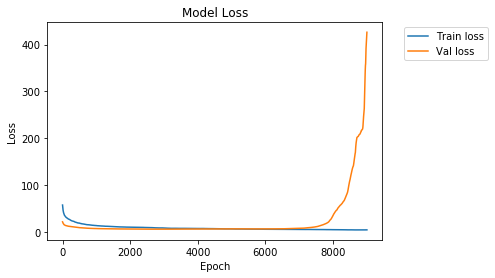

In [30]:
#Plot model loss

w = 1000
h1 = np.array(history.history['loss'])
h4 = np.array(history.history['val_loss'])
h1 = moving_average(h1,w)
h4 = moving_average(h4,w)
plt.plot(h1,label='Train loss')
plt.plot(h4,label='Val loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1),loc='best')
plt.show()

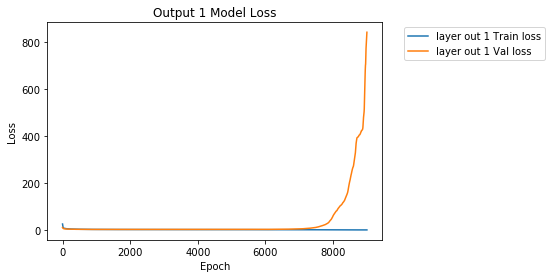

In [31]:
#Plot output 1 loss

h2 = np.array(history.history['out1_loss'])
h5 = np.array(history.history['val_out1_loss'])
h2 = moving_average(h2,w)
h5 = moving_average(h5,w)
plt.plot(h2,label='layer out 1 Train loss')
plt.plot(h5,label='layer out 1 Val loss')
plt.title('Output 1 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1),loc='best')
plt.show()

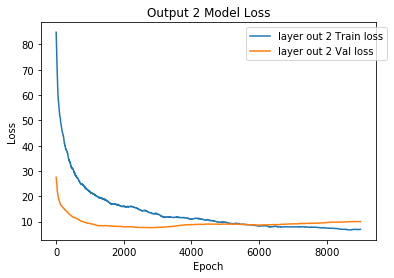

In [32]:
#Plot output 2 loss

h3 = np.array(history.history['out2_loss'])
h6 = np.array(history.history['val_out2_loss'])
h3 = moving_average(h3,w)
h6 = moving_average(h6,w)
plt.plot(h3,label='layer out 2 Train loss')
plt.plot(h6,label='layer out 2 Val loss')
plt.title('Output 2 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1),loc='best')
plt.show()

In [27]:
#Load ground truth RUL

thr = mat['thr']
fleet_NUM = np.arange(0,pad,1)

rul = pd.read_csv(rul_file,index_col=False)
rul = (rul-1)/(thr-1)
rul_Fleet_All = np.zeros(100)
for x in range(100):
    rul_Fleet_All[x] = rul['RUL'][x]
rul_Fleet_All_Full = ((thr-1)*rul_Fleet_All) + 1
rul_Fleet_All_Full

array([50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
       50., 50., 50., 50., 28., 50., 16., 50., 50., 50., 20., 50., 50.,
       50., 50., 50., 50.,  8., 48., 50.,  7., 11., 19., 21., 50., 50.,
       28., 18., 10., 50., 50., 50., 47., 50., 50., 21., 50., 50., 29.,
       26., 50., 50., 15., 50., 37., 50., 50., 21., 50., 50., 28., 50.,
       14., 50.,  8., 50., 50., 50., 50., 50., 50., 50., 10., 34., 50.,
       50., 50.,  8.,  9., 50., 50., 50., 50., 50., 50., 50., 28., 38.,
       20., 50., 50., 50., 50., 50., 50., 50., 20.])

In [33]:
#Make 100 predictions and calculate average RMSE & Score

import sklearn
import math
from sklearn import metrics

rmse = np.zeros(100)
rmse1 = np.zeros(100)
sc = np.zeros(100)
sc1 = np.zeros(100)

for i in range(100):
    
    preds = model(x_test)
    tens_draw = preds[0].sample(1000)
    tens_draw1 = preds[1].sample(1000)
    tens_draw2 = preds[2]
    tens_draw = tf.keras.backend.get_value(tens_draw)
    tens_draw1 = tf.keras.backend.get_value(tens_draw1)
    tens_draw2 = tf.keras.backend.get_value(tens_draw2)

    #RMSE with AU

    mean_Fleet_All = np.zeros(tens_draw.shape[1])
    mean_Fleet = np.zeros(tens_draw.shape[0])
    for y in range(tens_draw.shape[1]):
        for x in range(tens_draw.shape[0]):
            mean_Fleet[x] = tens_draw[x,y,0]
        mean_Fleet_All[y] = mean_Fleet.mean()

    RUL_mse = sklearn.metrics.mean_squared_error(rul_Fleet_All_Full, mean_Fleet_All)
    RUL_rmse = math.sqrt(RUL_mse)
    rmse[i] = RUL_rmse

    #RMSE with EU

    mean_Fleet_All1 = np.zeros(tens_draw1.shape[1])
    mean_Fleet1 = np.zeros(tens_draw1.shape[0])
    for y in range(tens_draw1.shape[1]):
        for x in range(tens_draw1.shape[0]):
            mean_Fleet1[x] = tens_draw1[x,y,0]
        mean_Fleet_All1[y] = mean_Fleet1.mean()

    RUL_mse1 = sklearn.metrics.mean_squared_error(rul_Fleet_All_Full, mean_Fleet_All1)
    RUL_rmse1 = math.sqrt(RUL_mse1)
    rmse1[i] = RUL_rmse1
    
    score = mean_Fleet_All-rul_Fleet_All_Full

    for j in range(100):
        if score[j]<0:
            score[j]= math.exp((-score[j])/13)-1
        else:
            score[j] = math.exp(score[j]/10)-1
    
    sc[i] = np.sum(score)
    
    score1 = mean_Fleet_All1-rul_Fleet_All_Full

    for j in range(100):
        if score1[j]<0:
            score1[j]= math.exp((-score1[j])/13)-1
        else:
            score1[j] = math.exp(score1[j]/10)-1
    
    sc1[i] = np.sum(score1)

In [34]:
#Average RMSE with AU & EU
np.mean(rmse),np.mean(rmse1)

(16.203625308440266, 17.09020754678244)

In [35]:
#Average early prediction Score with AU & EU
np.mean(sc),np.mean(sc1)

(724.1331535886638, 897.3837508135948)

In [61]:
#Calculate Mean & Std of prediction with AU

Fleet = pd.DataFrame(np.zeros((pad,tens_draw.shape[0])))
mean = pd.DataFrame(np.zeros((pad,tens_draw.shape[1])))
std = pd.DataFrame(np.zeros((pad,tens_draw.shape[1])))
for z in range(tens_draw.shape[1]):
    for y in range(tens_draw.shape[0]):
        for x in range(pad):
            Fleet[y][x] = tens_draw[y,z,x]
    row_Mean = Fleet.mean(axis=1)
    row_Std = Fleet.std(axis=1)
    for j in range(pad):
        mean[z][j] = row_Mean[j]
    for k in range(pad):
        std[z][k] = row_Std[k]

In [62]:
#Calculate Mean & Std of prediction with EU

Fleet1 = pd.DataFrame(np.zeros((pad,tens_draw1.shape[0])))
mean1 = pd.DataFrame(np.zeros((pad,tens_draw1.shape[1])))
std1 = pd.DataFrame(np.zeros((pad,tens_draw1.shape[1])))
for z in range(tens_draw1.shape[1]):
    for y in range(tens_draw1.shape[0]):
        for x in range(pad):
            Fleet1[y][x] = tens_draw1[y,z,x]
    row_Mean = Fleet1.mean(axis=1)
    row_Std = Fleet1.std(axis=1)
    for j in range(pad):
        mean1[z][j] = row_Mean[j]
    for k in range(pad):
        std1[z][k] = row_Std[k]

In [63]:
#Load ground truth RUL

fleet_RUL = pd.read_csv(fleet_Rul_File, skiprows = 0,header = None)

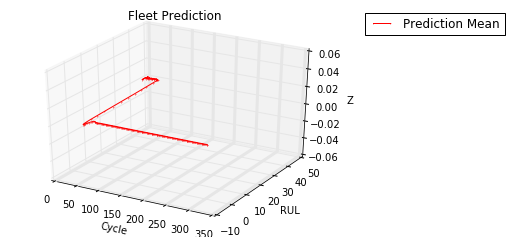

In [89]:
#3d visualization of prediction

from mpl_toolkits import mplot3d
import seaborn as sns
from scipy import stats
from scipy.stats import norm
plt.style.use('classic')
%matplotlib inline
ax = plt.axes(projection='3d')
ax.xaxis._axinfo["grid"].update({"linewidth":3})

i = 17

ax.set_title("Fleet Prediction")
ax.set_xlabel('Cycle')
ax.set_ylabel('RUL')
ax.set_zlabel('Z')


mu = mean[0][i]
sigma = std[0][i]
x = np.full((1000,),i)
s = np.arange(0,303,1)
Fleet1 = Fleet.iloc[i:i+1,:].to_numpy()
Fleet1 = Fleet1.reshape(1000,)
mindist = Fleet1.min()
maxdist = Fleet1.max()
y = np.linspace(mindist,maxdist,1000)
ax.plot3D(s,mean[0],linewidth=1,marker="+",markersize=1,color='red',label='Prediction Mean')
#ax.scatter3D(x,Fleet1,marker= "o",color='grey',linewidth=0.2,label='Predictions')
#ax.plot3D(x,y,stats.norm.pdf(y, mu, sigma),color='blue',label='Prediction Distribution')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('3D_1.jpg',bbox_inches='tight')
plt.show()

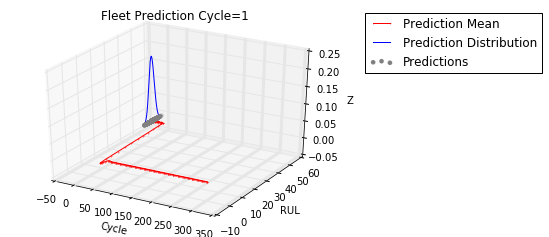

In [90]:
#3d visualization of prediction

plt.style.use('classic')
%matplotlib inline
ax = plt.axes(projection='3d')
ax.xaxis._axinfo["grid"].update({"linewidth":3})

i = 0

ax.set_title("Fleet Prediction Cycle=1")
ax.set_xlabel('Cycle')
ax.set_ylabel('RUL')
ax.set_zlabel('Z')


mu = mean[0][i]
sigma = std[0][i]
x = np.full((1000,),i)
s = np.arange(0,303,1)
Fleet1 = Fleet.iloc[i:i+1,:].to_numpy()
Fleet1 = Fleet1.reshape(1000,)
mindist = Fleet1.min()
maxdist = Fleet1.max()
y = np.linspace(mindist,maxdist,1000)
ax.plot3D(s,mean[0],linewidth=1,marker="+",markersize=1,color='red',label='Prediction Mean')
ax.scatter3D(x,Fleet1,marker= "o",color='grey',linewidth=0.1,label='Predictions')
ax.plot3D(x,y,stats.norm.pdf(y, mu, sigma),color='blue',label='Prediction Distribution')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('3D_1.jpg',bbox_inches='tight')
plt.show()

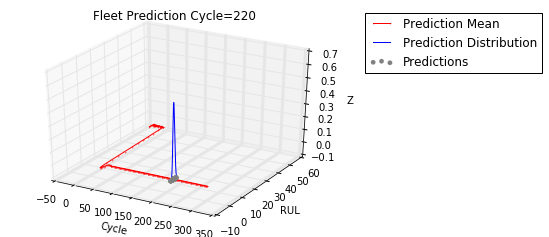

In [91]:
#3d visualization of prediction

plt.style.use('classic')
%matplotlib inline
ax = plt.axes(projection='3d')
ax.xaxis._axinfo["grid"].update({"linewidth":3})

i = 219

ax.set_title("Fleet Prediction Cycle=220")
ax.set_xlabel('Cycle')
ax.set_ylabel('RUL')
ax.set_zlabel('Z')


mu = mean[0][i]
sigma = std[0][i]
x = np.full((1000,),i)
s = np.arange(0,303,1)
Fleet1 = Fleet.iloc[i:i+1,:].to_numpy()
Fleet1 = Fleet1.reshape(1000,)
mindist = Fleet1.min()
maxdist = Fleet1.max()
y = np.linspace(mindist,maxdist,1000)
ax.plot3D(s,mean[0],linewidth=1,marker="+",markersize=1,color='red',label='Prediction Mean')
ax.scatter3D(x,Fleet1,marker= "o",color='grey',linewidth=0.2,label='Predictions')
ax.plot3D(x,y,stats.norm.pdf(y,mean[0][i],std[0][i]),color='blue',label='Prediction Distribution')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.savefig('3D_2.jpg',bbox_inches='tight')
plt.show()

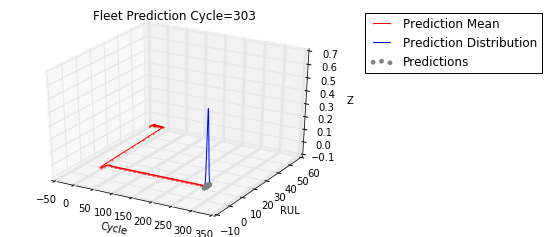

In [92]:
#3d visualization of prediction

plt.style.use('classic')
%matplotlib inline
ax = plt.axes(projection='3d')
ax.xaxis._axinfo["grid"].update({"linewidth":3})

i = 302

ax.set_title("Fleet Prediction Cycle=303")
ax.set_xlabel('Cycle')
ax.set_ylabel('RUL')
ax.set_zlabel('Z')


mu = mean[0][i]
sigma = std[0][i]
x = np.full((1000,),i)
s = np.arange(0,303,1)
Fleet1 = Fleet.iloc[i:i+1,:].to_numpy()
Fleet1 = Fleet1.reshape(1000,)
mindist = Fleet1.min()
maxdist = Fleet1.max()
y = np.linspace(mindist,maxdist,1000)
ax.plot3D(s,mean[0],linewidth=1,marker="+",markersize=1,color='red',label='Prediction Mean')
ax.scatter3D(x,Fleet1,marker= "o",color='grey',linewidth=0.2,label='Predictions')
ax.plot3D(x,y,stats.norm.pdf(y,mean[0][i],std[0][i]),color='blue',label='Prediction Distribution')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.savefig('3D_3.jpg',bbox_inches='tight')
plt.show()

In [64]:
#Define cycle when RUL ground truth become 0

cycle_lim = np.zeros(100)
S = 0
for K in range(100):
    for L in range(pad):
        if fleet_RUL[K][L] == 0:
            S = 0
            break
        else:
            S = S + 1
            cycle_lim[K] = S

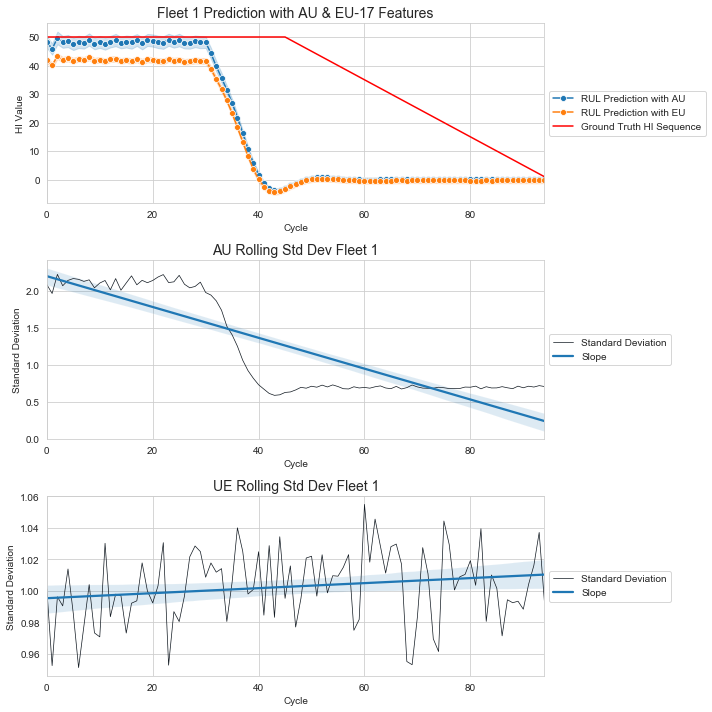

In [74]:
#Visualization Fleet 1

import seaborn as sns
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy import stats
sns.set_style("whitegrid")
for B in range(0,1):
    lim = int(cycle_lim[B]+1)
    lim2 = int(cycle_lim[B]+1)
    max_Seq = pd.DataFrame(np.zeros((lim,tens_draw.shape[0])))
    for y in range(tens_draw.shape[0]):
        for x in range(lim):
            max_Seq[y][x] = tens_draw[y,B,x]

    max_Seq_Arrange = pd.DataFrame(np.zeros((lim*tens_draw.shape[0],2)))
    z = 0
    m = 0
    s = 0
    while s < lim*tens_draw.shape[0]:
        if(m < (tens_draw.shape[0])):
            max_Seq_Arrange[0][s] = fleet_NUM[z]
            max_Seq_Arrange[1][s] = max_Seq[m][z]
            m = m + 1
            s = s + 1
        else:
            #print("change")
            z = z + 1
            m = 0
        continue
    
    max_Seq1 = pd.DataFrame(np.zeros((lim,tens_draw1.shape[0])))
    for y in range(tens_draw1.shape[0]):
        for x in range(lim):
            max_Seq1[y][x] = tens_draw1[y,B,x]

    max_Seq_Arrange1 = pd.DataFrame(np.zeros((lim*tens_draw1.shape[0],2)))
    z = 0
    m = 0
    s = 0
    while s < lim*tens_draw1.shape[0]:
        if(m < (tens_draw1.shape[0])):
            max_Seq_Arrange1[0][s] = fleet_NUM[z]
            max_Seq_Arrange1[1][s] = max_Seq1[m][z]
            m = m + 1
            s = s + 1
        else:
            #print("change")
            z = z + 1
            m = 0
        continue

    max_Seq_Arrange.columns = ['Cycle','HI Value']
    max_RUL_Arrange = pd.DataFrame(np.zeros((lim2,2)))
    for x in range(lim2):
        max_RUL_Arrange[0][x] = fleet_NUM[x]
        max_RUL_Arrange[1][x] = ((thr-1)*fleet_RUL[B][x]) + 1
    max_RUL_Arrange.columns = ['Cycle','HI Value']
    
    max_Seq_Arrange1.columns = ['Cycle','HI Value']

    min_Std_Arrange = pd.DataFrame(np.zeros((lim,2)))
    for x in range(lim):
        min_Std_Arrange[0][x] = fleet_NUM[x]
        min_Std_Arrange[1][x] = std[B][x]
    min_Std_Arrange.columns = ['Cycle','HI Value']
    
    med_Std_Arrange = pd.DataFrame(np.zeros((lim,2)))
    for x in range(lim):
        med_Std_Arrange[0][x] = fleet_NUM[x]
        med_Std_Arrange[1][x] = std1[B][x]
    med_Std_Arrange.columns = ['Cycle','HI Value']
    
    #get coeffs of linear fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(min_Std_Arrange['Cycle'],min_Std_Arrange['HI Value'])
    gs = gridspec.GridSpec(3,1)
    fig = plt.figure(figsize=(10,10))

    ax = fig.add_subplot(gs[0])
    sns.lineplot(x="Cycle", y="HI Value",ci = "sd", marker='o', data=max_Seq_Arrange, ax=ax, label="RUL Prediction with AU")
    sns.lineplot(x="Cycle", y="HI Value",ci = "sd", marker='o', data=max_Seq_Arrange1, ax=ax, label="RUL Prediction with EU")
    sns.lineplot(x="Cycle", y="HI Value", data = max_RUL_Arrange, color='red', ax=ax,label="Ground Truth HI Sequence")
    plt.title('Fleet %i Prediction with AU & EU-17 Features' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax = fig.add_subplot(gs[1],sharex=ax)
    ax.plot('Cycle', 'HI Value', data=min_Std_Arrange,linestyle= '-', color = '#101820FF',linewidth=0.7, label='Standard Deviation')
    sns.regplot(min_Std_Arrange['Cycle'],min_Std_Arrange['HI Value'],scatter = False,label='Slope')
    plt.title('AU Rolling Std Dev Fleet %i' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Standard Deviation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax = fig.add_subplot(gs[2],sharex=ax)
    ax.plot('Cycle', 'HI Value', data=med_Std_Arrange,linestyle= '-', color = '#101820FF',linewidth=0.7, label='Standard Deviation')
    sns.regplot(med_Std_Arrange['Cycle'],med_Std_Arrange['HI Value'],scatter = False,label='Slope')
    plt.title('UE Rolling Std Dev Fleet %i' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Standard Deviation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig("Fleet %i Pred" %B+'.jpg')
    plt.tight_layout()
    plt.show()

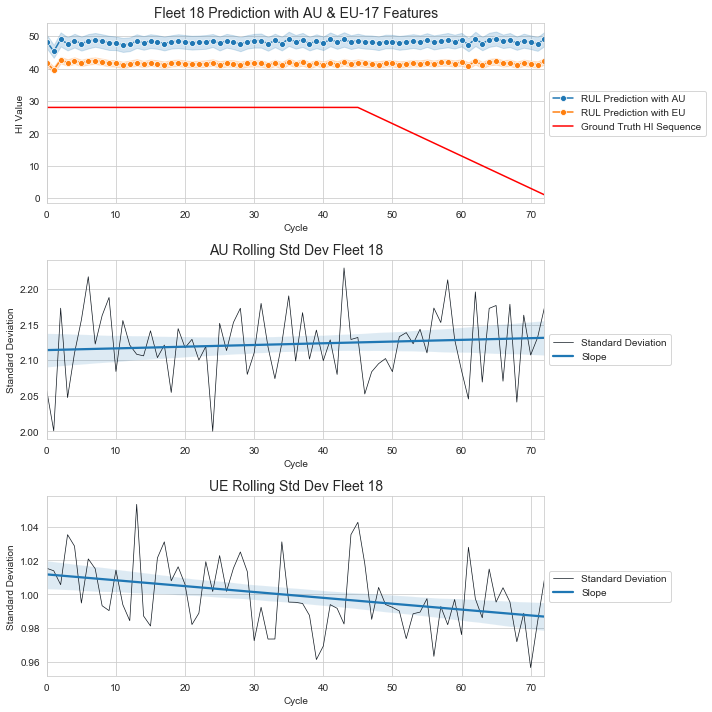

In [75]:
#Visualization Fleet 18

sns.set_style("whitegrid")
for B in range(17,18):
    lim = int(cycle_lim[B]+1)
    lim2 = int(cycle_lim[B]+1)
    max_Seq = pd.DataFrame(np.zeros((lim,tens_draw.shape[0])))
    for y in range(tens_draw.shape[0]):
        for x in range(lim):
            max_Seq[y][x] = tens_draw[y,B,x]

    max_Seq_Arrange = pd.DataFrame(np.zeros((lim*tens_draw.shape[0],2)))
    z = 0
    m = 0
    s = 0
    while s < lim*tens_draw.shape[0]:
        if(m < (tens_draw.shape[0])):
            max_Seq_Arrange[0][s] = fleet_NUM[z]
            max_Seq_Arrange[1][s] = max_Seq[m][z]
            m = m + 1
            s = s + 1
        else:
            #print("change")
            z = z + 1
            m = 0
        continue
    
    max_Seq1 = pd.DataFrame(np.zeros((lim,tens_draw1.shape[0])))
    for y in range(tens_draw1.shape[0]):
        for x in range(lim):
            max_Seq1[y][x] = tens_draw1[y,B,x]

    max_Seq_Arrange1 = pd.DataFrame(np.zeros((lim*tens_draw1.shape[0],2)))
    z = 0
    m = 0
    s = 0
    while s < lim*tens_draw1.shape[0]:
        if(m < (tens_draw1.shape[0])):
            max_Seq_Arrange1[0][s] = fleet_NUM[z]
            max_Seq_Arrange1[1][s] = max_Seq1[m][z]
            m = m + 1
            s = s + 1
        else:
            #print("change")
            z = z + 1
            m = 0
        continue

    max_Seq_Arrange.columns = ['Cycle','HI Value']
    max_RUL_Arrange = pd.DataFrame(np.zeros((lim2,2)))
    for x in range(lim2):
        max_RUL_Arrange[0][x] = fleet_NUM[x]
        max_RUL_Arrange[1][x] = ((thr-1)*fleet_RUL[B][x]) + 1
    max_RUL_Arrange.columns = ['Cycle','HI Value']
    
    max_Seq_Arrange1.columns = ['Cycle','HI Value']

    min_Std_Arrange = pd.DataFrame(np.zeros((lim,2)))
    for x in range(lim):
        min_Std_Arrange[0][x] = fleet_NUM[x]
        min_Std_Arrange[1][x] = std[B][x]
    min_Std_Arrange.columns = ['Cycle','HI Value']
    
    med_Std_Arrange = pd.DataFrame(np.zeros((lim,2)))
    for x in range(lim):
        med_Std_Arrange[0][x] = fleet_NUM[x]
        med_Std_Arrange[1][x] = std1[B][x]
    med_Std_Arrange.columns = ['Cycle','HI Value']
    
    #get coeffs of linear fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(min_Std_Arrange['Cycle'],min_Std_Arrange['HI Value'])
    gs = gridspec.GridSpec(3,1)
    fig = plt.figure(figsize=(10,10))

    ax = fig.add_subplot(gs[0])
    sns.lineplot(x="Cycle", y="HI Value",ci = "sd", marker='o', data=max_Seq_Arrange, ax=ax, label="RUL Prediction with AU")
    sns.lineplot(x="Cycle", y="HI Value",ci = "sd", marker='o', data=max_Seq_Arrange1, ax=ax, label="RUL Prediction with EU")
    sns.lineplot(x="Cycle", y="HI Value", data = max_RUL_Arrange, color='red', ax=ax,label="Ground Truth HI Sequence")
    plt.title('Fleet %i Prediction with AU & EU-17 Features' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax = fig.add_subplot(gs[1],sharex=ax)
    ax.plot('Cycle', 'HI Value', data=min_Std_Arrange,linestyle= '-', color = '#101820FF',linewidth=0.7, label='Standard Deviation')
    sns.regplot(min_Std_Arrange['Cycle'],min_Std_Arrange['HI Value'],scatter = False,label='Slope')
    plt.title('AU Rolling Std Dev Fleet %i' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Standard Deviation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax = fig.add_subplot(gs[2],sharex=ax)
    ax.plot('Cycle', 'HI Value', data=med_Std_Arrange,linestyle= '-', color = '#101820FF',linewidth=0.7, label='Standard Deviation')
    sns.regplot(med_Std_Arrange['Cycle'],med_Std_Arrange['HI Value'],scatter = False,label='Slope')
    plt.title('UE Rolling Std Dev Fleet %i' %(B+1),fontsize=14)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Standard Deviation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig("Fleet %i Pred" %B+'.jpg')
    plt.tight_layout()
    plt.show()

In [26]:
#SHAP cannot be used with model with probabilistic layers. So, transfer learned weights of probabilistic LSTM to a new LSTM without probabilistic layers
#Define New LSTM without probabilistic layers for explanation

inputs = tf.keras.Input(shape=(303,17),dtype='float32')
layer1 = LSTM(unit1,return_sequences = True)(inputs)
layer2 = Dense(size1)(layer1)
layer3 = Dense(1)(layer2)
layer4 = Lambda(lambda t: t[:,-1],name='out2')(layer3)
model2 = tf.keras.Model(inputs=inputs, outputs=layer4)
model2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 303, 17)]         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 303, 64)           20992     
_________________________________________________________________
dense_3 (Dense)              (None, 303, 364)          23660     
_________________________________________________________________
dense_4 (Dense)              (None, 303, 1)            365       
_________________________________________________________________
out2 (Lambda)                (None, 1)                 0         
Total params: 45,017
Trainable params: 45,017
Non-trainable params: 0
_________________________________________________________________


In [27]:
#Transfer weights from old LSTM to new LSTM

model2.layers[0].set_weights(model.layers[0].get_weights())
model2.layers[1].set_weights(model.layers[1].get_weights())
model2.layers[2].set_weights(model.layers[2].get_weights())
model2.layers[3].set_weights(model.layers[5].get_weights())
model2.layers[4].set_weights(model.layers[8].get_weights())

In [28]:
#Prediction with new LSTM

preds2 = model2(x_test)
y3 = preds2
y3 = tf.keras.backend.get_value(y3)
tens_draw3 = y3

In [29]:
#Import SHAP & initialized JS

import shap
shap.initjs()

In [30]:
#Extract Feature Names

features = pd.read_csv(train_file, index_col=False)
features = features.drop(['Fleet','Cycle','RUL'],axis=1)
features = np.array(list(features.columns))
features

array(['OC1', 'OC2', 'OC3', 'S2', 'S3', 'S4', 'S7', 'S8', 'S9', 'S11',
       'S12', 'S13', 'S14', 'S15', 'S17', 'S20', 'S21'], dtype='<U3')

In [31]:
#load Training Files into Pandas Dataframes for SHAP Plots

xtrain = pd.read_csv(train_file, index_col=False)
xtrain = xtrain.drop(['Fleet','Cycle','RUL'],axis=1)

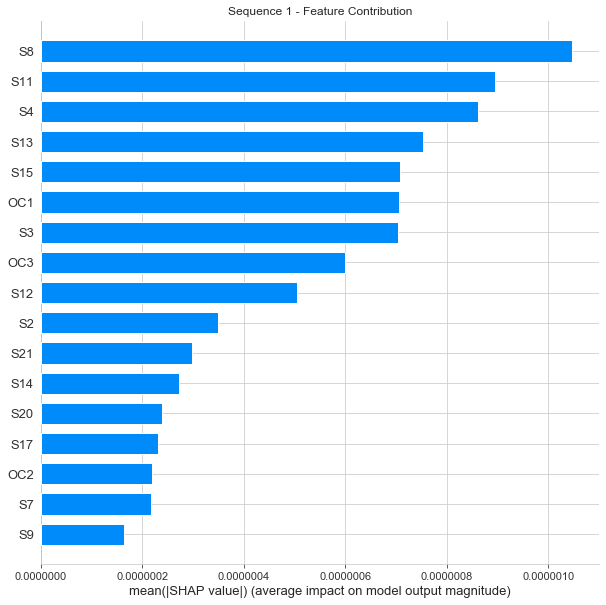

In [85]:
#SHAP Summmary Plot Fleet 1

instance = x_train
instance2 = x_test
explainer = shap.DeepExplainer(model2,instance)
shap_values = explainer.shap_values(instance2)
for i in range(0,1):
    shap.summary_plot(shap_values[0][i],feature_names=xtrain.columns,show=False,plot_size=(10, 10),plot_type="bar")
    plt.title("Sequence %i - Feature Contribution" %(i+1),fontsize=12)
    #plt.savefig("Sum_Plot %i" %i+'.png')
    #plt.figure

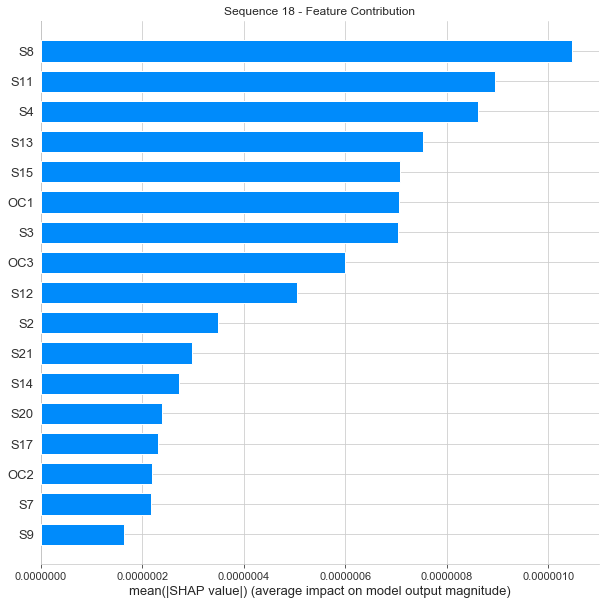

In [86]:
#SHAP Summary Plot Fleet 18

for i in range(17,18):
    shap.summary_plot(shap_values[0][i],feature_names=xtrain.columns,show=False,plot_size=(10, 10),plot_type="bar")
    plt.title("Sequence %i - Feature Contribution" %(i+1),fontsize=12)

In [87]:
#SHAP Force Plot Fleet 1

sns.set_style("ticks")
instance2 = x_train
explainer = shap.DeepExplainer(model2,instance2)
for s in range(0,1):
    instance=x_test[s:s+1]
    shap_values = explainer.shap_values(instance)
    e = explainer.expected_value
    #Per individual array 
    for j in range(303):
        print(s+1,j+1)
        xtest_df = pd.DataFrame(data = x_test[s][j].reshape(1,17),columns=features).round(3)
        shap_display = shap.force_plot(e[0],shap_values[0][0][j],xtest_df,matplotlib = False,show = False,figsize=(10, 2),text_rotation=15)
        display(shap_display)

1 1


1 2


1 3


1 4


1 5


1 6


1 7


1 8


1 9


1 10


1 11


1 12


1 13


1 14


1 15


1 16


1 17


1 18


1 19


1 20


1 21


1 22


1 23


1 24


1 25


1 26


1 27


1 28


1 29


1 30


1 31


1 32


1 33


1 34


1 35


1 36


1 37


1 38


1 39


1 40


1 41


1 42


1 43


1 44


1 45


1 46


1 47


1 48


1 49


1 50


1 51


1 52


1 53


1 54


1 55


1 56


1 57


1 58


1 59


1 60


1 61


1 62


1 63


1 64


1 65


1 66


1 67


1 68


1 69


1 70


1 71


1 72


1 73


1 74


1 75


1 76


1 77


1 78


1 79


1 80


1 81


1 82


1 83


1 84


1 85


1 86


1 87


1 88


1 89


1 90


1 91


1 92


1 93


1 94


1 95


1 96


1 97


1 98


1 99


1 100


1 101


1 102


1 103


1 104


1 105


1 106


1 107


1 108


1 109


1 110


1 111


1 112


1 113


1 114


1 115


1 116


1 117


1 118


1 119


1 120


1 121


1 122


1 123


1 124


1 125


1 126


1 127


1 128


1 129


1 130


1 131


1 132


1 133


1 134


1 135


1 136


1 137


1 138


1 139


1 140


1 141


1 142


1 143


1 144


1 145


1 146


1 147


1 148


1 149


1 150


1 151


1 152


1 153


1 154


1 155


1 156


1 157


1 158


1 159


1 160


1 161


1 162


1 163


1 164


1 165


1 166


1 167


1 168


1 169


1 170


1 171


1 172


1 173


1 174


1 175


1 176


1 177


1 178


1 179


1 180


1 181


1 182


1 183


1 184


1 185


1 186


1 187


1 188


1 189


1 190


1 191


1 192


1 193


1 194


1 195


1 196


1 197


1 198


1 199


1 200


1 201


1 202


1 203


1 204


1 205


1 206


1 207


1 208


1 209


1 210


1 211


1 212


1 213


1 214


1 215


1 216


1 217


1 218


1 219


1 220


1 221


1 222


1 223


1 224


1 225


1 226


1 227


1 228


1 229


1 230


1 231


1 232


1 233


1 234


1 235


1 236


1 237


1 238


1 239


1 240


1 241


1 242


1 243


1 244


1 245


1 246


1 247


1 248


1 249


1 250


1 251


1 252


1 253


1 254


1 255


1 256


1 257


1 258


1 259


1 260


1 261


1 262


1 263


1 264


1 265


1 266


1 267


1 268


1 269


1 270


1 271


1 272


1 273


1 274


1 275


1 276


1 277


1 278


1 279


1 280


1 281


1 282


1 283


1 284


1 285


1 286


1 287


1 288


1 289


1 290


1 291


1 292


1 293


1 294


1 295


1 296


1 297


1 298


1 299


1 300


1 301


1 302


1 303


In [88]:
#SHAP Force Plot Fleet 18

for s in range(17,18):
    instance=x_test[s:s+1]
    shap_values = explainer.shap_values(instance)
    e = explainer.expected_value
    #Per individual array 
    for j in range(303):
        print(s+1,j+1)
        xtest_df = pd.DataFrame(data = x_test[s][j].reshape(1,17),columns=features).round(3)
        shap_display = shap.force_plot(e[0],shap_values[0][0][j],xtest_df,matplotlib = False,show = False,figsize=(10, 2),text_rotation=15)
        display(shap_display)

18 1


18 2


18 3


18 4


18 5


18 6


18 7


18 8


18 9


18 10


18 11


18 12


18 13


18 14


18 15


18 16


18 17


18 18


18 19


18 20


18 21


18 22


18 23


18 24


18 25


18 26


18 27


18 28


18 29


18 30


18 31


18 32


18 33


18 34


18 35


18 36


18 37


18 38


18 39


18 40


18 41


18 42


18 43


18 44


18 45


18 46


18 47


18 48


18 49


18 50


18 51


18 52


18 53


18 54


18 55


18 56


18 57


18 58


18 59


18 60


18 61


18 62


18 63


18 64


18 65


18 66


18 67


18 68


18 69


18 70


18 71


18 72


18 73


18 74


18 75


18 76


18 77


18 78


18 79


18 80


18 81


18 82


18 83


18 84


18 85


18 86


18 87


18 88


18 89


18 90


18 91


18 92


18 93


18 94


18 95


18 96


18 97


18 98


18 99


18 100


18 101


18 102


18 103


18 104


18 105


18 106


18 107


18 108


18 109


18 110


18 111


18 112


18 113


18 114


18 115


18 116


18 117


18 118


18 119


18 120


18 121


18 122


18 123


18 124


18 125


18 126


18 127


18 128


18 129


18 130


18 131


18 132


18 133


18 134


18 135


18 136


18 137


18 138


18 139


18 140


18 141


18 142


18 143


18 144


18 145


18 146


18 147


18 148


18 149


18 150


18 151


18 152


18 153


18 154


18 155


18 156


18 157


18 158


18 159


18 160


18 161


18 162


18 163


18 164


18 165


18 166


18 167


18 168


18 169


18 170


18 171


18 172


18 173


18 174


18 175


18 176


18 177


18 178


18 179


18 180


18 181


18 182


18 183


18 184


18 185


18 186


18 187


18 188


18 189


18 190


18 191


18 192


18 193


18 194


18 195


18 196


18 197


18 198


18 199


18 200


18 201


18 202


18 203


18 204


18 205


18 206


18 207


18 208


18 209


18 210


18 211


18 212


18 213


18 214


18 215


18 216


18 217


18 218


18 219


18 220


18 221


18 222


18 223


18 224


18 225


18 226


18 227


18 228


18 229


18 230


18 231


18 232


18 233


18 234


18 235


18 236


18 237


18 238


18 239


18 240


18 241


18 242


18 243


18 244


18 245


18 246


18 247


18 248


18 249


18 250


18 251


18 252


18 253


18 254


18 255


18 256


18 257


18 258


18 259


18 260


18 261


18 262


18 263


18 264


18 265


18 266


18 267


18 268


18 269


18 270


18 271


18 272


18 273


18 274


18 275


18 276


18 277


18 278


18 279


18 280


18 281


18 282


18 283


18 284


18 285


18 286


18 287


18 288


18 289


18 290


18 291


18 292


18 293


18 294


18 295


18 296


18 297


18 298


18 299


18 300


18 301


18 302


18 303
